# Global Config & Styling

In [81]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.figsize': (8, 5),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Color-palette
ARCH_COLORS = {
    'MLP': '#2ecc71',           # Grün
    'MLP (B-Spline)': '#3498db', # Blau
    'KAN (B-Spline)': '#e74c3c', # Rot
    'KAN (Mean)': '#9b59b6',     # Lila
    'KAN (GR-KAN)': '#f39c12'    # Orange
}

ARCH_ORDER = ['MLP', 'MLP (B-Spline)', 'KAN (B-Spline)', 'KAN (Mean)', 'KAN (GR-KAN)']
SIZE_ORDER = ['tiny', 'small', 'base']

# Config
ENTITY = "" # wandb-account required
PROJECT = ""
GROUP = "Analysis"

api = wandb.Api()
runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": GROUP, "state": "finished"})

name_map = {
    'kan_bspline': 'KAN (B-Spline)',
    'kan_grkan': 'KAN (GR-KAN)',
    'kan_mean': 'KAN (Mean)',
    'mlp': 'MLP',
    'mlp_bspline': 'MLP (B-Spline)'
}

print(f"Found Runs: {len(runs)}")

Found Runs: 90


# Data Preprocessing

In [62]:
import re

data_summary = []
data_history = []

print("Loading data...")

for i, run in enumerate(runs):
    if i % 5 == 0:
        print(f"  Run {i+1}/{len(runs)}: {run.name}")

    summary = run.summary._json_dict
    config = run.config

    raw_arch = config.get("arch", "unknown")
    arch_name = name_map.get(raw_arch, raw_arch)
    size_name = config.get("size", "unknown")
    task_name = config.get("task", "unknown")

    # Meta-data
    meta = {
        "run_id": run.id,
        "name": run.name,
        "gpu_type": config.get("gpu", "unknown"),
    }

    # Experiment meta-data
    experiment = {
        "arch": raw_arch,
        "Architecture": arch_name,
        "size": size_name,
        "task": task_name,
        "seed": config.get("seed", None),
	    "dataset": summary.get("dataset", config.get("dataset", "unknown")),
        "total_params": summary.get("total_params", config.get("total_params", np.nan)),
        "params_non_embed": summary.get("params_non_embed", config.get("params_non_embed", np.nan)),
        "d_model": summary.get("d_model", config.get("d_model", np.nan)),
        "d_ff": summary.get("d_ff", config.get("d_ff", np.nan)),
        "n_heads": summary.get("n_heads", config.get("n_heads", np.nan)),
        "n_layers": summary.get("n_layers", config.get("n_layers", np.nan)),
        "batch_size": summary.get("batch_size", config.get("batch_size", np.nan)),
    }

    # Parse seed from name as fallback
    if experiment["seed"] is None and "_s" in run.name:
        match = re.search(r'_s(\d+)', run.name)
        if match:
            experiment["seed"] = int(match.group(1))

    # Metrics
    metrics = {
        "time_min": summary.get("total_time_min", summary.get("_runtime", 0) / 60),
        "total_epochs": summary.get("total_epochs", np.nan),
        "best_epoch": summary.get("best_epoch", np.nan),
        "epoch_time": summary.get("epoch_time", np.nan),
        "inference_ms": summary.get("inference_ms", np.nan),
        "peak_mem_gb": summary.get("peak_mem_gb", np.nan),

        # Test-Metrics
        "test_acc": summary.get("test_acc", np.nan),
        "test_f1": summary.get("test_f1", np.nan),
        "test_ppl": summary.get("test_ppl", np.nan),

        # Train-Metrics
        "train_acc": summary.get("train_acc", summary.get("train/epoch_avg_acc", np.nan)),
        "train_ppl": summary.get("train_ppl", summary.get("train/epoch_avg_ppl", np.nan)),

        # Val-Metrics
        "val_acc": summary.get("val/acc", np.nan),
        "val_ppl": summary.get("val/ppl", np.nan),
        "best_val_f1": summary.get("best_val_f1", np.nan),
        "best_val_ppl": summary.get("best_val_ppl", np.nan),
    }

    data_summary.append({**meta, **experiment, **metrics})

    # Load history
    try:
        hist = run.history(samples=50000)
        if not hist.empty:
            if 'epoch' not in hist.columns and '_step' in hist.columns:
                max_step = hist['_step'].max()
                tot_ep = metrics['total_epochs']
                if pd.notna(tot_ep) and tot_ep > 0 and max_step > 0:
                    hist['epoch'] = (hist['_step'] / max_step) * tot_ep

            if 'epoch' in hist.columns:
                hist['epoch'] = pd.to_numeric(hist['epoch'], errors='coerce')
                if hist['epoch'].min() >= 0.95:
                    hist['epoch'] = hist['epoch'] - 1

            hist = hist.assign(
                Architecture=arch_name,
                size=size_name,
                task=task_name,
                run_name=run.name,
            )
            data_history.append(hist)
    except Exception as e:
        print(f"ERROR fetching history for run {run.name}: {e}")

df_summary = pd.DataFrame(data_summary)

if data_history:
    df_history = pd.concat(data_history, ignore_index=True)
    print(f"History found: {df_history.shape[0]} rows")
else:
    df_history = pd.DataFrame()
    print("No history data found!")

# Generalization Gap
if not df_summary.empty:
    # Classification
    df_summary['gen_gap_acc'] = df_summary['train_acc'] - df_summary['test_acc']

    # Language Modeling
    df_summary['gen_gap_ppl'] = df_summary['test_ppl'] - df_summary['train_ppl']

# Split by task
df_cls = df_summary[df_summary["task"] == "classification"].copy()
df_lm = df_summary[df_summary["task"] == "language_modelling"].copy()

if not df_history.empty:
    hist_cls = df_history[df_history["task"] == "classification"].copy()
    hist_lm = df_history[df_history["task"] == "language_modelling"].copy()
else:
    hist_cls, hist_lm = pd.DataFrame(), pd.DataFrame()

print(f"\nClassification: {len(df_cls)} Runs")
print(f"Language Modeling: {len(df_lm)} Runs")

Loading data...
  Run 1/90: classification_mlp_tiny_s42
  Run 6/90: classification_mlp_tiny_s1337
  Run 11/90: classification_mlp_tiny_s2024
  Run 16/90: classification_mlp_small_s42
  Run 21/90: classification_mlp_small_s1337
  Run 26/90: classification_mlp_small_s2024
  Run 31/90: classification_mlp_base_s42
  Run 36/90: classification_mlp_base_s1337
  Run 41/90: classification_mlp_base_s2024
  Run 46/90: language_modelling_mlp_tiny_s42
  Run 51/90: language_modelling_mlp_tiny_s1337
  Run 56/90: language_modelling_mlp_tiny_s2024
  Run 61/90: language_modelling_mlp_small_s42
  Run 66/90: language_modelling_mlp_base_s42
  Run 71/90: language_modelling_mlp_base_s1337
  Run 76/90: language_modelling_mlp_base_s2024
  Run 81/90: language_modelling_mlp_small_s1337
  Run 86/90: language_modelling_mlp_small_s2024
History found: 133824 rows

Classification: 45 Runs
Language Modeling: 45 Runs


In [63]:
# Check unique configurations per size and architecture
config_cols = ["task", "dataset", "batch_size", "d_model", "n_heads", "n_layers", "d_ff", "total_params", "params_non_embed"]

model_specs = df_summary.groupby(["size", "Architecture"])[config_cols].first().reset_index()

# Sort
size_order = ["tiny", "small", "base"]
model_specs["size"] = pd.Categorical(model_specs["size"], categories=size_order, ordered=True)
model_specs = model_specs.sort_values(["size", "Architecture"])

print("=== Model Specifications per Size ===")
display(model_specs)
model_specs.to_csv("results/model_specifications.csv", index=False)

=== Model Specifications per Size ===


,size,Architecture,task,dataset,batch_size,d_model,n_heads,n_layers,d_ff,total_params,params_non_embed
10,tiny,KAN (B-Spline),classification,ag_news,32,192,3,12,77,15084868,5337220
11,tiny,KAN (GR-KAN),classification,ag_news,32,192,3,12,768,15112132,5364484
12,tiny,KAN (Mean),classification,ag_news,32,192,3,12,77,15084868,5337220
13,tiny,MLP,classification,ag_news,32,192,3,12,768,15087172,5339524
14,tiny,MLP (B-Spline),classification,ag_news,32,192,3,12,768,15179332,5431684
5,small,KAN (B-Spline),classification,ag_news,32,384,6,12,154,40804996,21309700
6,small,KAN (GR-KAN),classification,ag_news,32,384,6,12,1536,40839172,21343876
7,small,KAN (Mean),classification,ag_news,32,384,6,12,154,40804996,21309700
8,small,MLP,classification,ag_news,32,384,6,12,1536,40791172,21295876
9,small,MLP (B-Spline),classification,ag_news,32,384,6,12,1536,40975492,21480196


# Overview Table

In [64]:
def format_mean_std(x):
    return f"{x.mean():.2f} ± {x.std():.2f}"

# Aggregation
summary_table_cls = df_cls.groupby(["Architecture", "size"]).agg({
    "test_acc": format_mean_std,
    "test_f1": format_mean_std,
	"total_epochs": format_mean_std,
	"best_epoch": format_mean_std,
	"epoch_time": format_mean_std,
	"time_min": format_mean_std,
    "inference_ms": format_mean_std,
	"peak_mem_gb": format_mean_std,
}).reset_index()

print("--- Descriptive statistics (Classification) ---")
display(summary_table_cls)

summary_table_cls.to_csv("results/classification_summary.csv", index=False)

# Export to latex
#print(summary_table_cls.to_latex(index=False))

# Aggregation
summary_table_lm = df_lm.groupby(["Architecture", "size"]).agg({
    "test_ppl": format_mean_std,
	"total_epochs": format_mean_std,
	"best_epoch": format_mean_std,
	"epoch_time": format_mean_std,
	"time_min": format_mean_std,
    "inference_ms": format_mean_std,
	"peak_mem_gb": format_mean_std,
}).reset_index()

print("--- Descriptive statistics (Language Modelling) ---")
display(summary_table_lm)

summary_table_lm.to_csv("results/language_modelling_summary.csv", index=False)

# Export to latex
#print(summary_table_lm.to_latex(index=False))

--- Descriptive statistics (Classification) ---


,Architecture,size,test_acc,test_f1,total_epochs,best_epoch,epoch_time,time_min,inference_ms,peak_mem_gb
0,KAN (B-Spline),base,91.45 ± 0.01,91.41 ± 0.00,5.00 ± 0.00,2.00 ± 0.00,207.22 ± 0.12,18.87 ± 0.59,1.83 ± 0.00,5.58 ± 0.01
1,KAN (B-Spline),small,91.75 ± 0.26,91.73 ± 0.27,4.67 ± 0.58,1.67 ± 0.58,88.61 ± 0.17,8.28 ± 1.44,1.42 ± 0.01,2.51 ± 0.01
2,KAN (B-Spline),tiny,91.84 ± 0.13,91.82 ± 0.12,5.00 ± 0.00,2.00 ± 0.00,51.81 ± 0.06,5.20 ± 0.00,1.41 ± 0.01,1.16 ± 0.00
3,KAN (GR-KAN),base,91.96 ± 0.05,91.93 ± 0.04,4.67 ± 0.58,1.67 ± 0.58,204.90 ± 0.39,20.19 ± 0.98,3.33 ± 0.02,5.36 ± 0.00
4,KAN (GR-KAN),small,91.70 ± 0.28,91.67 ± 0.27,5.00 ± 0.00,2.00 ± 0.00,91.49 ± 0.95,11.50 ± 1.75,3.24 ± 0.13,7.90 ± 0.00
5,KAN (GR-KAN),tiny,91.79 ± 0.17,91.78 ± 0.16,5.67 ± 1.15,2.67 ± 1.15,55.37 ± 0.20,6.51 ± 0.93,0.86 ± 0.01,0.99 ± 0.00
6,KAN (Mean),base,91.38 ± 0.05,91.34 ± 0.05,5.33 ± 0.58,2.33 ± 0.58,206.35 ± 0.24,19.78 ± 1.90,1.83 ± 0.00,5.59 ± 0.00
7,KAN (Mean),small,91.75 ± 0.16,91.74 ± 0.17,5.00 ± 0.00,2.00 ± 0.00,88.26 ± 0.14,8.68 ± 0.62,1.43 ± 0.00,2.51 ± 0.00
8,KAN (Mean),tiny,91.81 ± 0.07,91.78 ± 0.06,5.33 ± 0.58,2.33 ± 0.58,51.54 ± 0.05,5.49 ± 0.51,1.42 ± 0.01,1.16 ± 0.00
9,MLP,base,91.63 ± 0.10,91.62 ± 0.09,5.33 ± 0.58,2.33 ± 0.58,193.10 ± 0.40,18.10 ± 1.80,1.09 ± 0.00,5.00 ± 0.01


--- Descriptive statistics (Language Modelling) ---


,Architecture,size,test_ppl,total_epochs,best_epoch,epoch_time,time_min,inference_ms,peak_mem_gb
0,KAN (B-Spline),base,86.53 ± 0.43,21.67 ± 0.58,16.67 ± 0.58,205.27 ± 0.07,77.03 ± 1.80,2.00 ± 0.00,9.59 ± 0.00
1,KAN (B-Spline),small,90.25 ± 0.55,42.00 ± 3.46,37.00 ± 3.46,102.31 ± 0.08,74.28 ± 6.02,1.53 ± 0.00,6.01 ± 0.00
2,KAN (B-Spline),tiny,102.39 ± 0.32,98.33 ± 2.08,95.00 ± 4.58,55.11 ± 0.22,93.57 ± 2.09,1.38 ± 0.01,5.26 ± 0.00
3,KAN (GR-KAN),base,91.28 ± 0.56,16.67 ± 0.58,11.67 ± 0.58,143.10 ± 0.11,41.61 ± 1.54,1.29 ± 0.00,9.38 ± 0.00
4,KAN (GR-KAN),small,88.36 ± 0.33,38.33 ± 0.58,33.33 ± 0.58,72.75 ± 0.05,48.45 ± 0.64,1.36 ± 0.02,5.89 ± 0.00
5,KAN (GR-KAN),tiny,95.07 ± 0.58,80.33 ± 13.50,75.33 ± 13.50,43.20 ± 0.03,60.21 ± 10.02,0.86 ± 0.00,5.26 ± 0.00
6,KAN (Mean),base,92.29 ± 0.11,22.33 ± 0.58,17.33 ± 0.58,204.45 ± 0.03,79.00 ± 2.16,2.00 ± 0.00,9.60 ± 0.00
7,KAN (Mean),small,98.32 ± 0.56,64.67 ± 2.08,59.67 ± 2.08,102.08 ± 0.06,114.00 ± 3.60,1.55 ± 0.00,6.01 ± 0.00
8,KAN (Mean),tiny,115.92 ± 0.25,99.33 ± 0.58,95.33 ± 2.31,54.89 ± 0.02,94.33 ± 0.73,1.39 ± 0.01,5.26 ± 0.00
9,MLP,base,77.26 ± 0.04,16.33 ± 0.58,11.33 ± 0.58,132.19 ± 0.08,37.62 ± 1.30,1.26 ± 0.00,9.30 ± 0.00


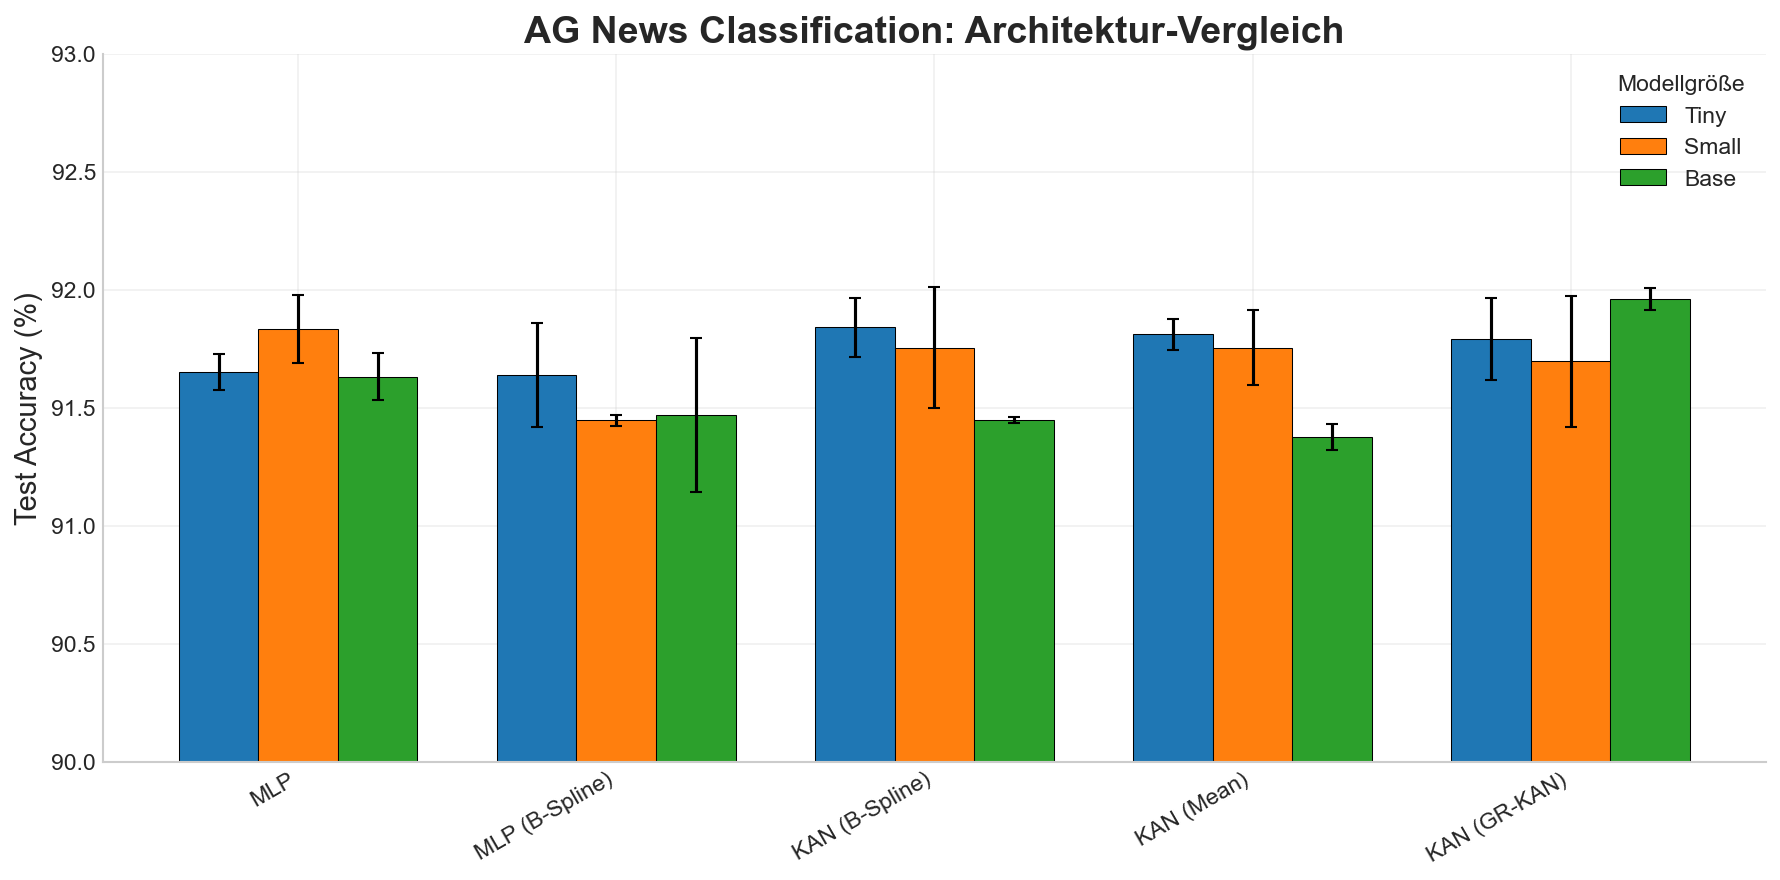

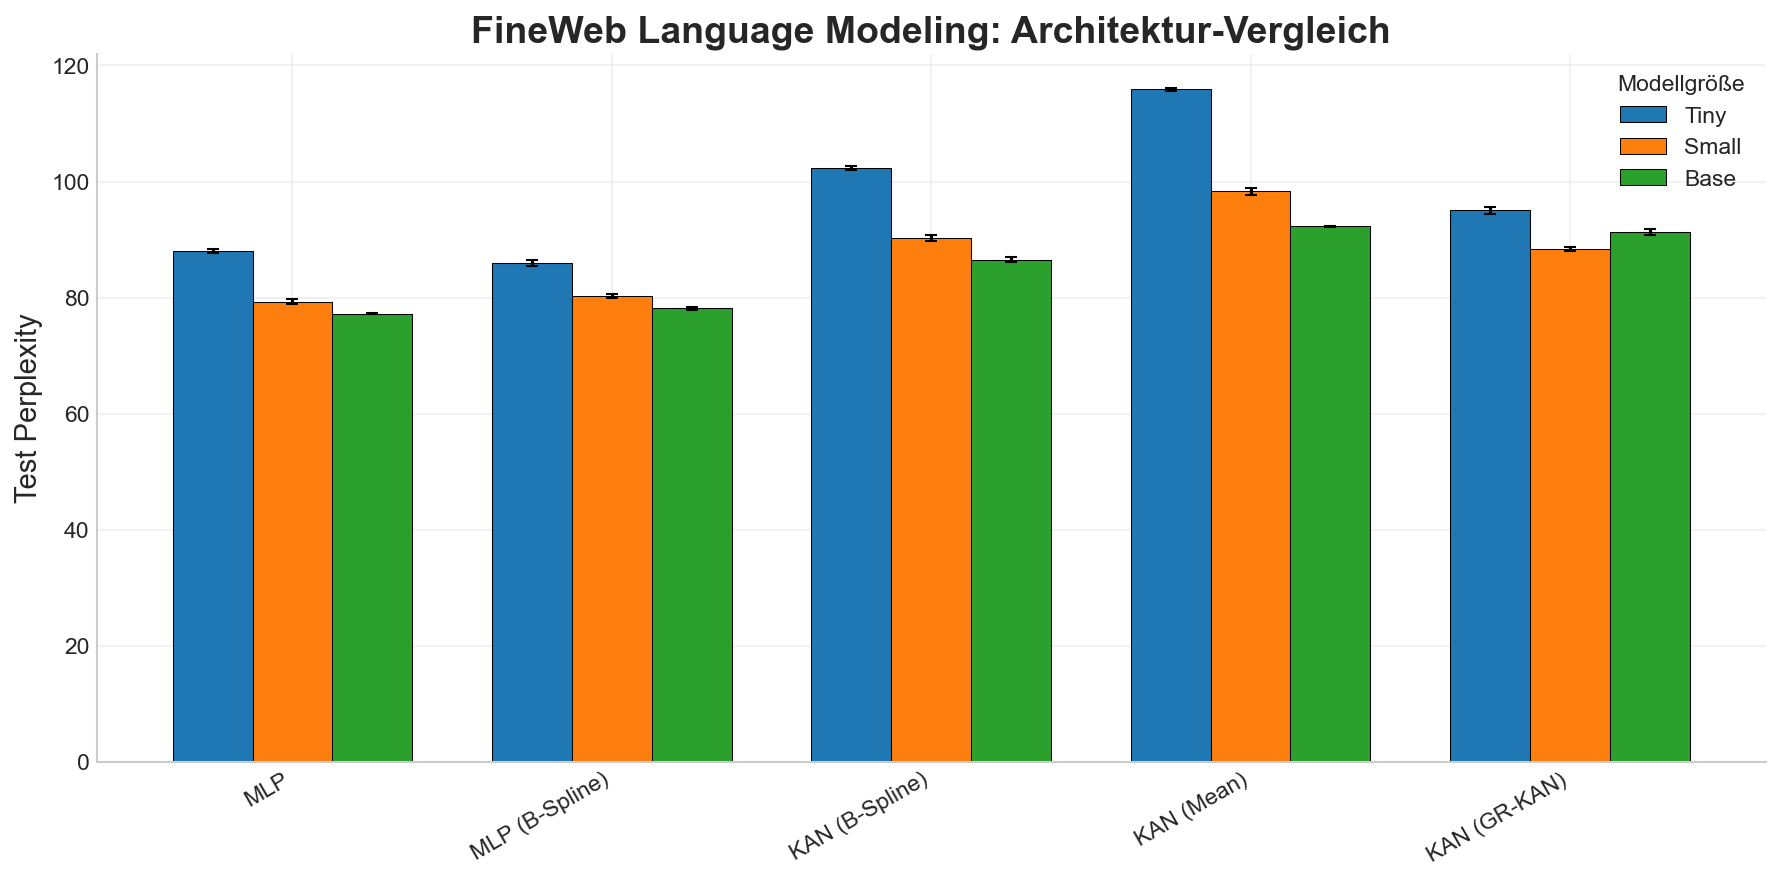

In [82]:
def plot_performance_comparison(df, metric, ylabel, title, lower_better=False, ylim=None):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Aggregate data
    stats = df.groupby(['Architecture', 'size'])[metric].agg(['mean', 'std']).reset_index()

    # Sort
    stats['arch_order'] = stats['Architecture'].map({a: i for i, a in enumerate(ARCH_ORDER)})
    stats['size_order'] = stats['size'].map({s: i for i, s in enumerate(SIZE_ORDER)})
    stats = stats.sort_values(['arch_order', 'size_order'])

    n_arch = len(ARCH_ORDER)
    n_sizes = len(SIZE_ORDER)
    bar_width = 0.25

    for i, size in enumerate(SIZE_ORDER):
        size_data = stats[stats['size'] == size]
        x_positions = np.arange(n_arch) + i * bar_width

        ax.bar(x_positions, size_data['mean'],
               width=bar_width,
               yerr=size_data['std'],
               label=size.capitalize(),
               capsize=3,
               edgecolor='black',
               linewidth=0.5)

    ax.set_xticks(np.arange(n_arch) + bar_width)
    ax.set_xticklabels(ARCH_ORDER, rotation=30, ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight='bold')
    ax.legend(title='Modellgröße')

    if ylim:
        ax.set_ylim(ylim)

    plt.tight_layout()
    return fig

# Classification
if not df_cls.empty:
    fig_cls = plot_performance_comparison(
        df_cls, 'test_acc',
        'Test Accuracy (%)',
        'AG News Classification: Architektur-Vergleich',
        ylim=(90, 93)
    )
    fig_cls.savefig('results/plot_cls_performance.png')
    plt.show()

# Language Modeling
if not df_lm.empty:
    fig_lm = plot_performance_comparison(
        df_lm, 'test_ppl',
        'Test Perplexity',
        'FineWeb Language Modeling: Architektur-Vergleich',
        lower_better=True
    )
    fig_lm.savefig('results/plot_lm_performance.png')
    plt.show()

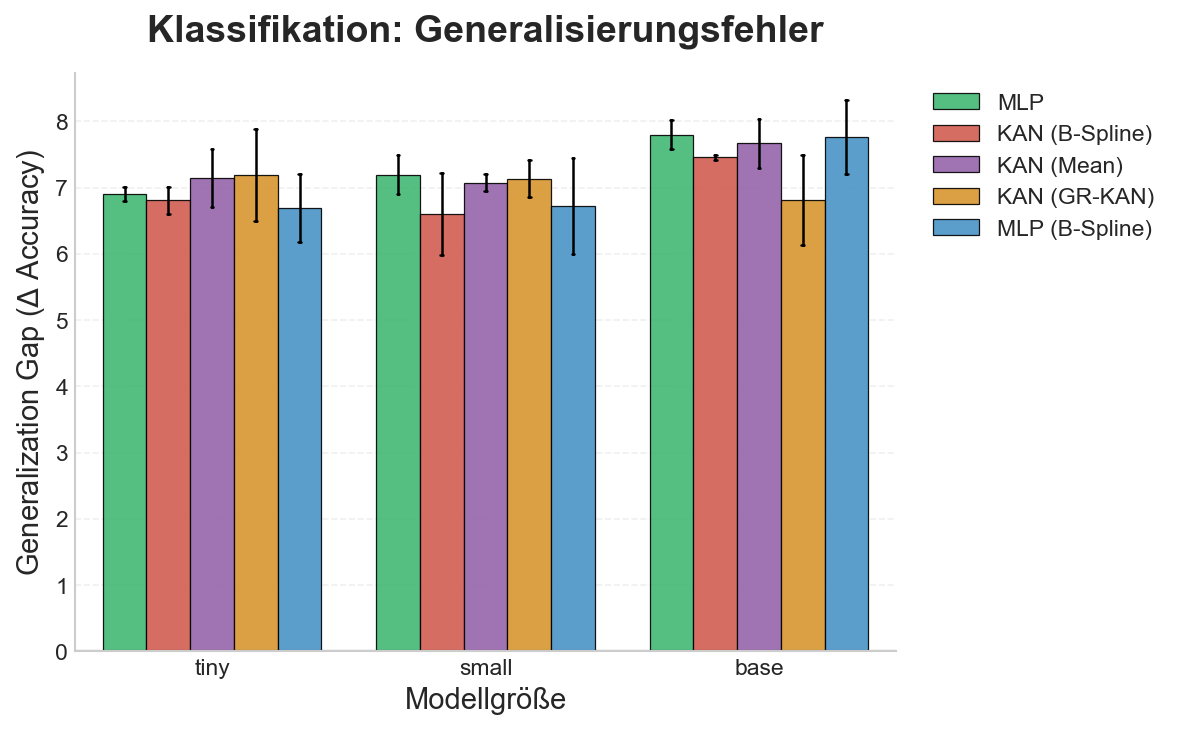

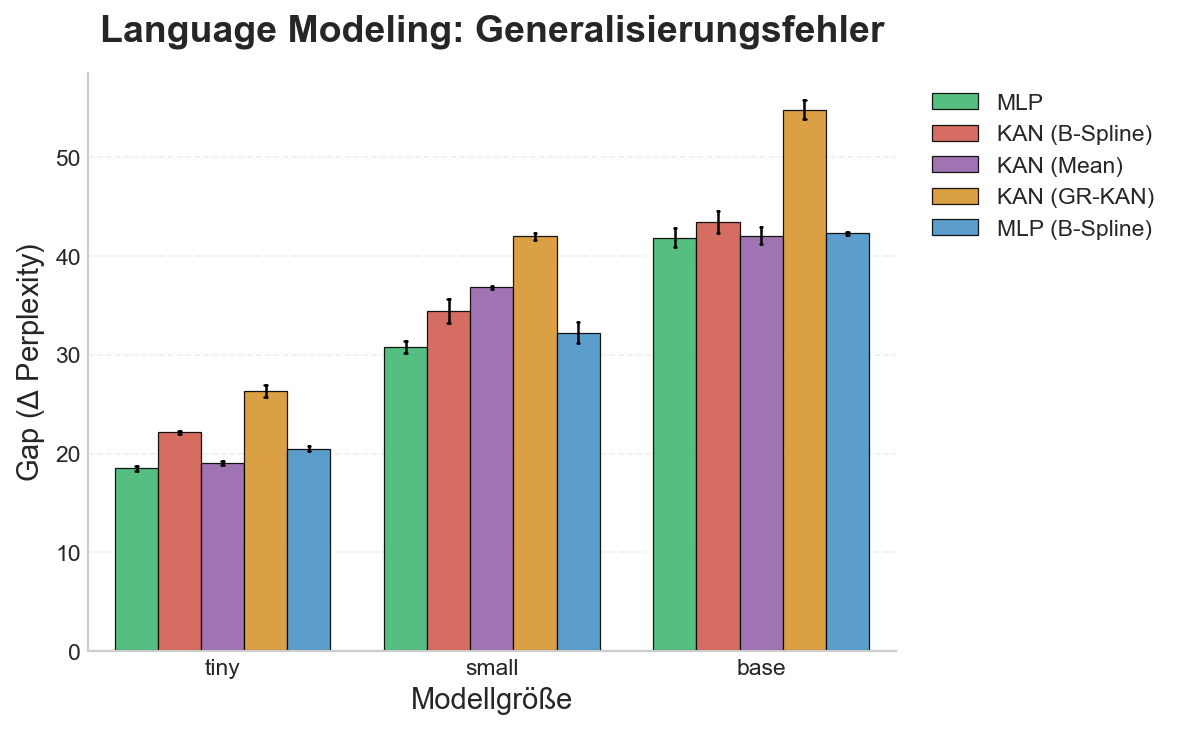

In [83]:
def plot_generalization_gap(df, x_col, y_col, hue_col, ylabel, title, filename, colors=None):
    fig, ax = plt.subplots(figsize=(8, 5))

    # Barplot
    sns.barplot(
        data=df,
        x=x_col,
        y=y_col,
        hue=hue_col,
        errorbar="sd",
        palette=colors if colors else "viridis",
        alpha=0.9,
        edgecolor='black',
        linewidth=0.6,
        ax=ax,
        capsize=0.05,
        err_kws={'linewidth': 1.2, 'color': 'black'}
    )

    ax.axhline(0, color='black', linewidth=1)

    # Grid
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

    # Labels
    ax.set_title(title, fontweight='bold', pad=15)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Modellgröße')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1), frameon=False, title=None)

    sns.despine()

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Classification
plot_generalization_gap(
    df=df_cls,
    x_col='size',
    y_col='gen_gap_acc',
    hue_col='Architecture',
    ylabel=r'Generalization Gap ($\Delta$ Accuracy)',
    title='Klassifikation: Generalisierungsfehler',
    filename="results/generalization_gap_cls.png",
    colors=ARCH_COLORS if 'ARCH_COLORS' in locals() else None
)

# Language Modeling
plot_generalization_gap(
    df=df_lm,
    x_col='size',
    y_col='gen_gap_ppl',
    hue_col='Architecture',
    ylabel=r'Gap ($\Delta$ Perplexity)',
    title='Language Modeling: Generalisierungsfehler',
    filename="results/generalization_gap_lm.png",
    colors=ARCH_COLORS if 'ARCH_COLORS' in locals() else None
)

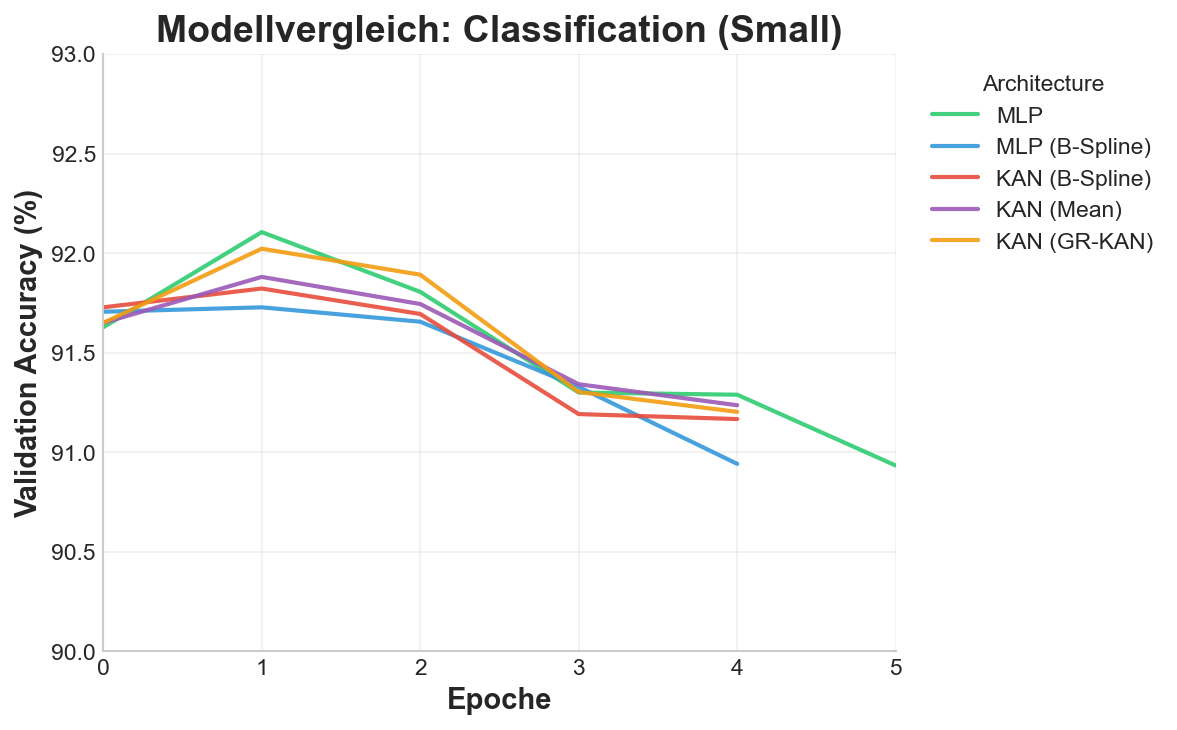

In [84]:
def plot_comparison_final(df_history, task="classification", size="small", metric="acc",
                          ylim=(90, 95)):

    metrics_map = {"acc": ("val/acc", "Validation Accuracy (%)")}
    if metric not in metrics_map: return
    val_col, ylabel = metrics_map[metric]

    df = df_history[(df_history["task"] == task) & (df_history["size"] == size)].copy()
    if df.empty: return

    # Skalieren auf Prozent
    if df[val_col].max() <= 1.05:
        df[val_col] *= 100

    df['Architecture'] = pd.Categorical(df['Architecture'], categories=ARCH_ORDER, ordered=True)
    df = df.dropna(subset=[val_col])

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))

    sns.lineplot(
        data=df, x="epoch", y=val_col, hue="Architecture",
        palette=ARCH_COLORS, style="Architecture",
        dashes=False,
        linewidth=2.0,
        alpha=0.9,
        errorbar=None,
        ax=ax
    )

    # Zoom
    ax.set_ylim(bottom=ylim[0], top=ylim[1])
    ax.set_xlim(left=0, right=df["epoch"].max())

    # Style
    ax.set_title(f"Modellvergleich: {task.title()} ({size.title()})", fontweight='bold')
    ax.set_xlabel("Epoche", fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legende
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, title="Architecture")

    plt.tight_layout()
    plt.savefig(f"results/comparison_zoomed_{task}_{size}.png", bbox_inches='tight')
    plt.show()

plot_comparison_final(hist_cls, task="classification", size="small", metric="acc", ylim=(90, 93))

# Train/Validate Plots

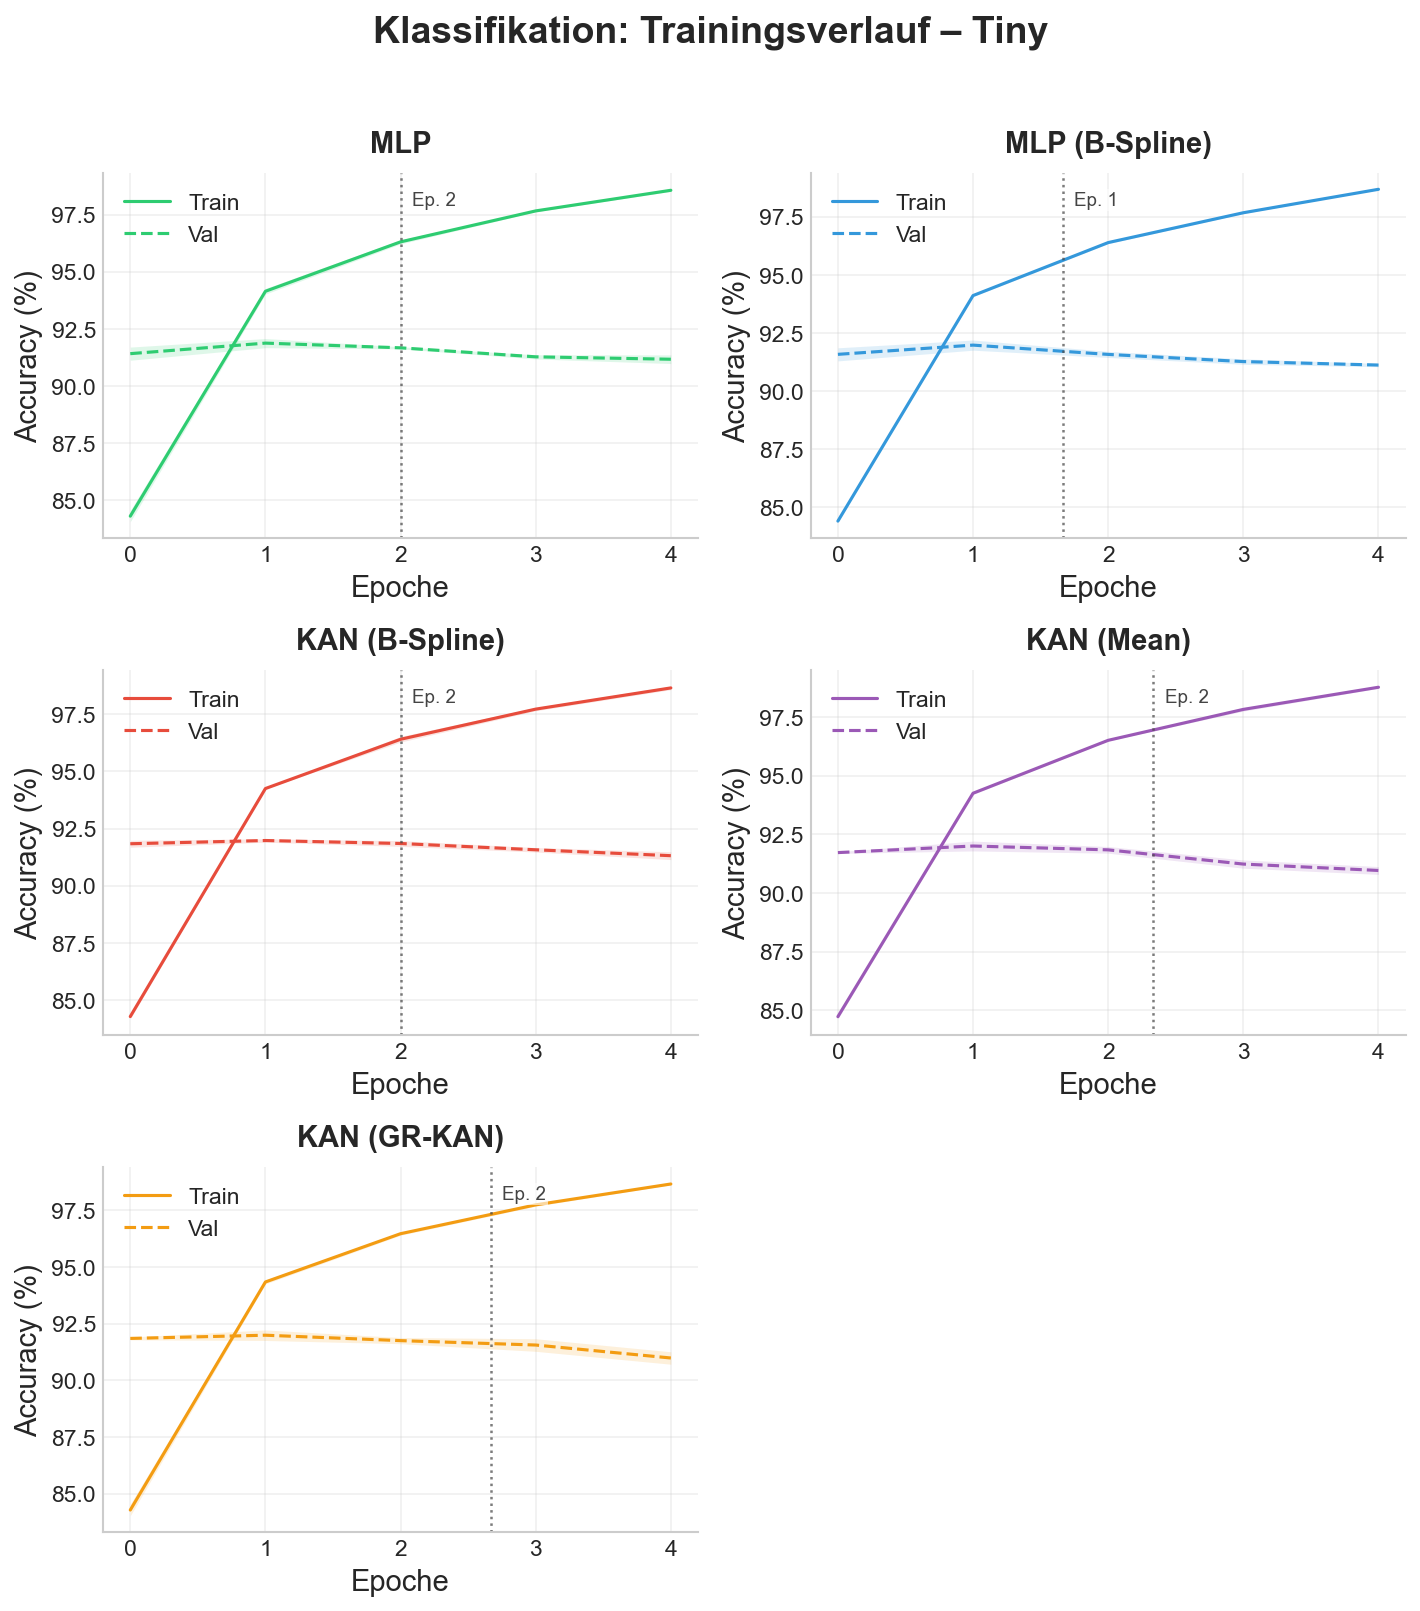

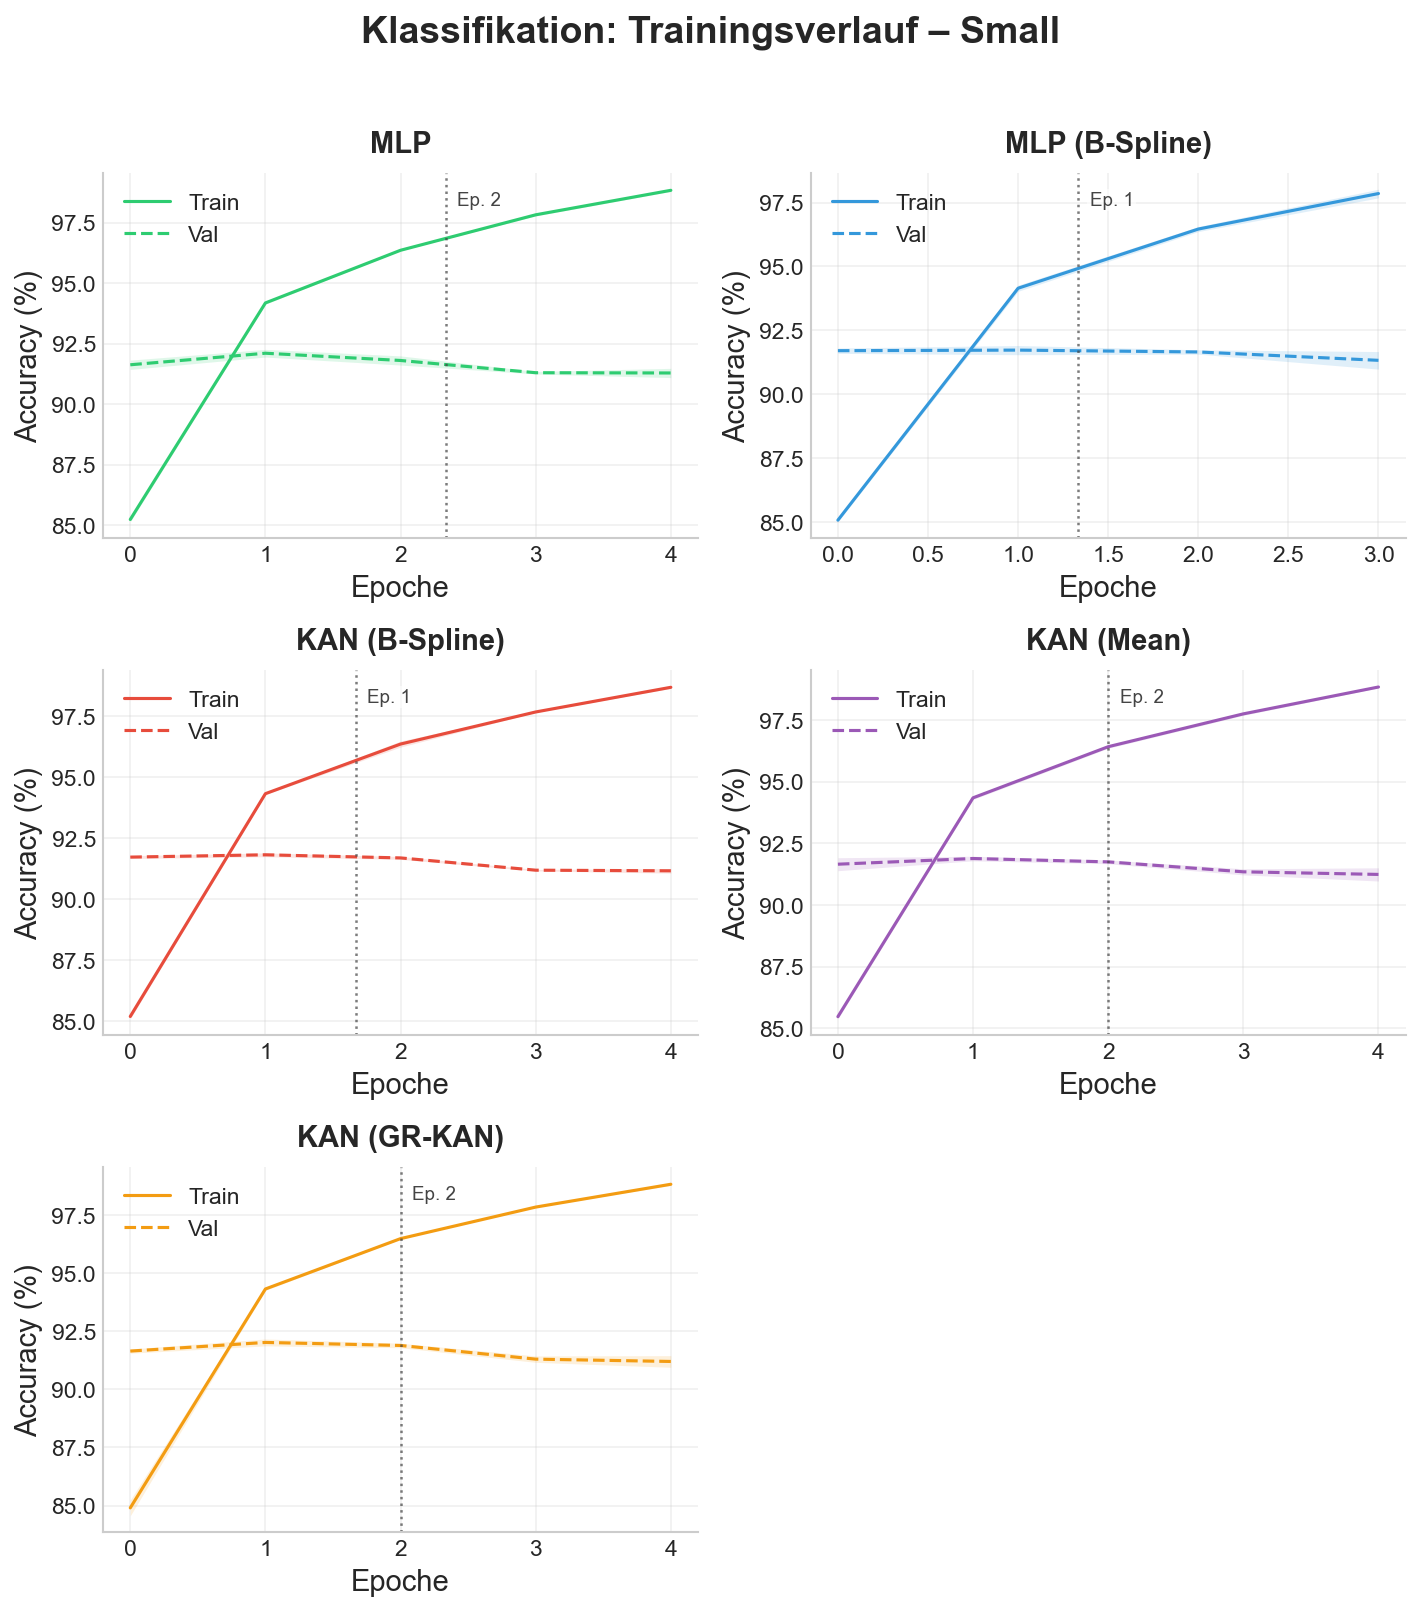

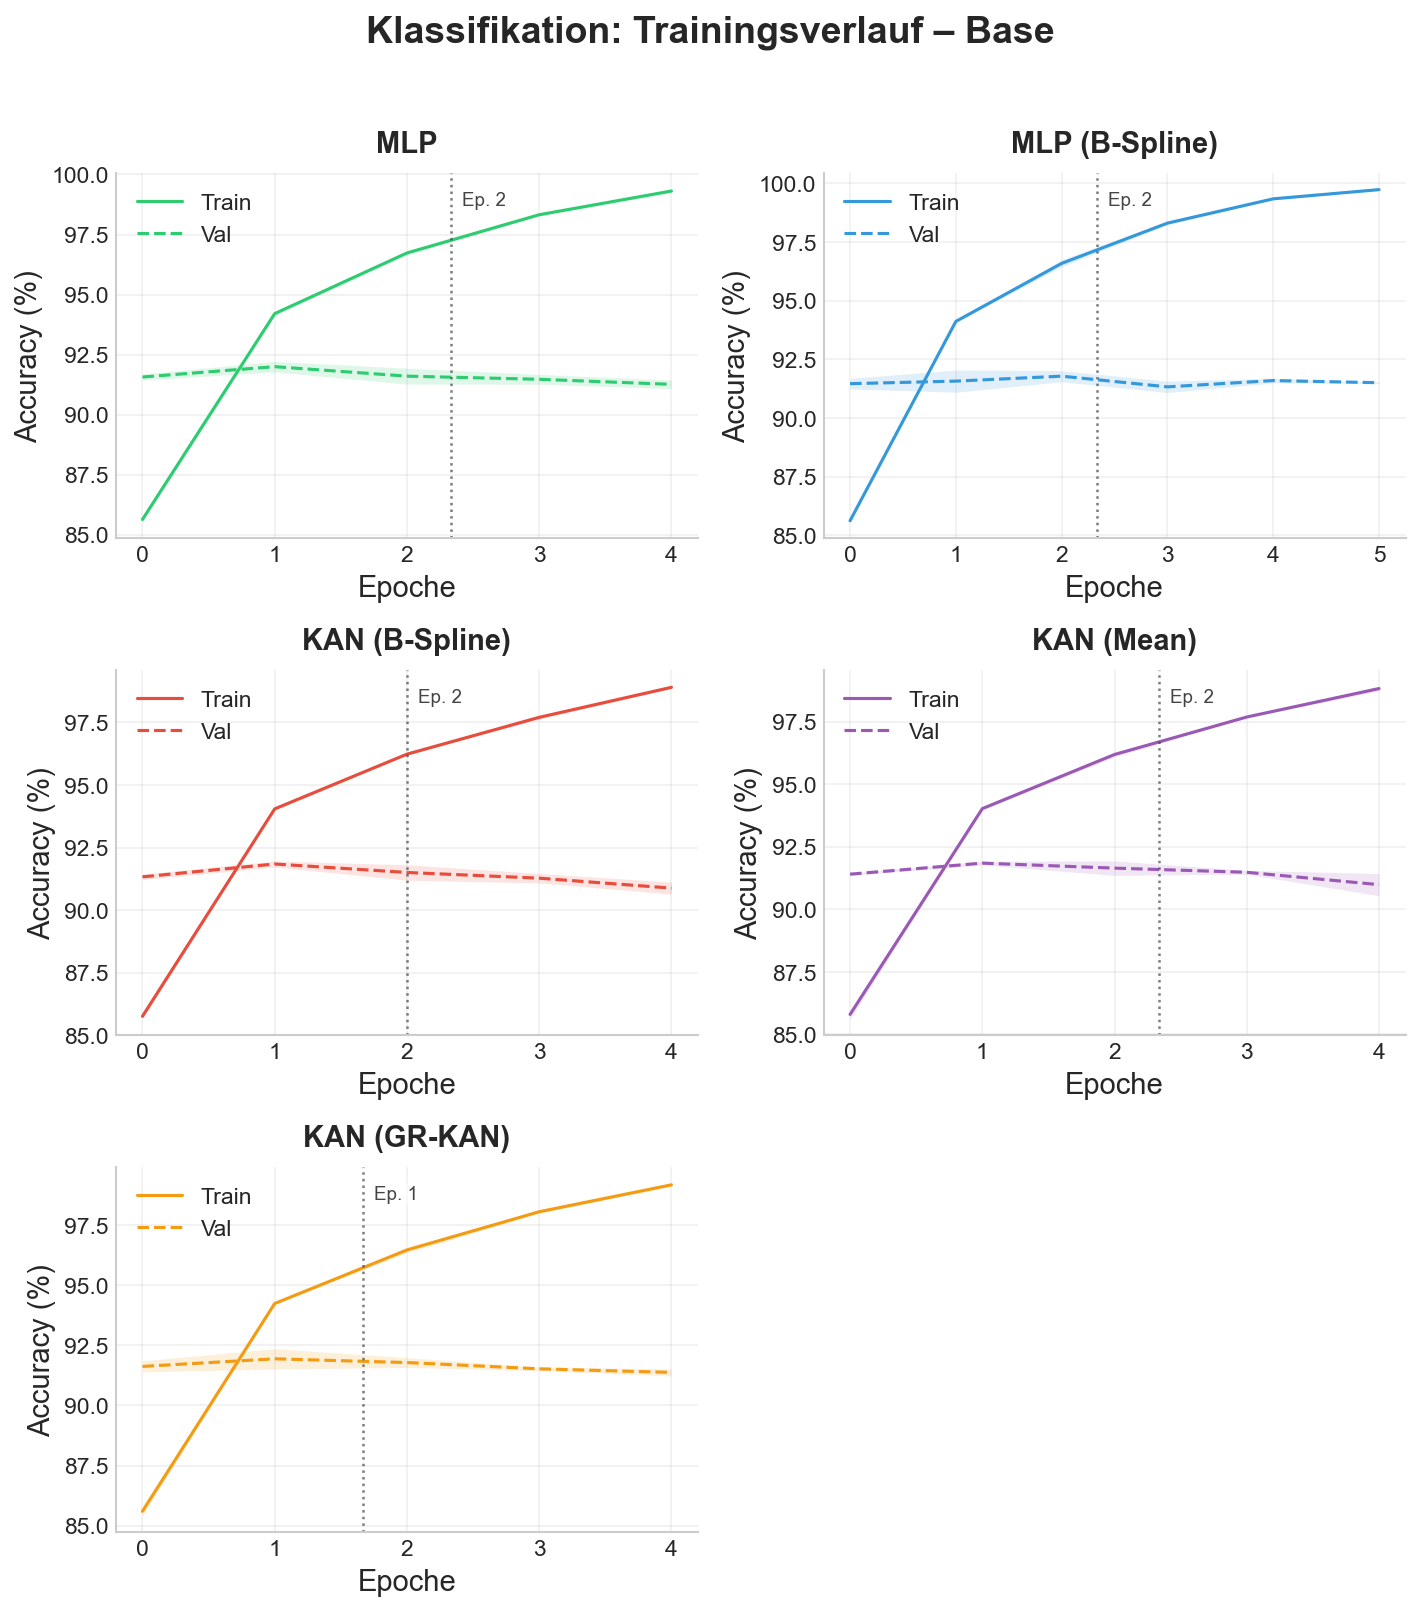

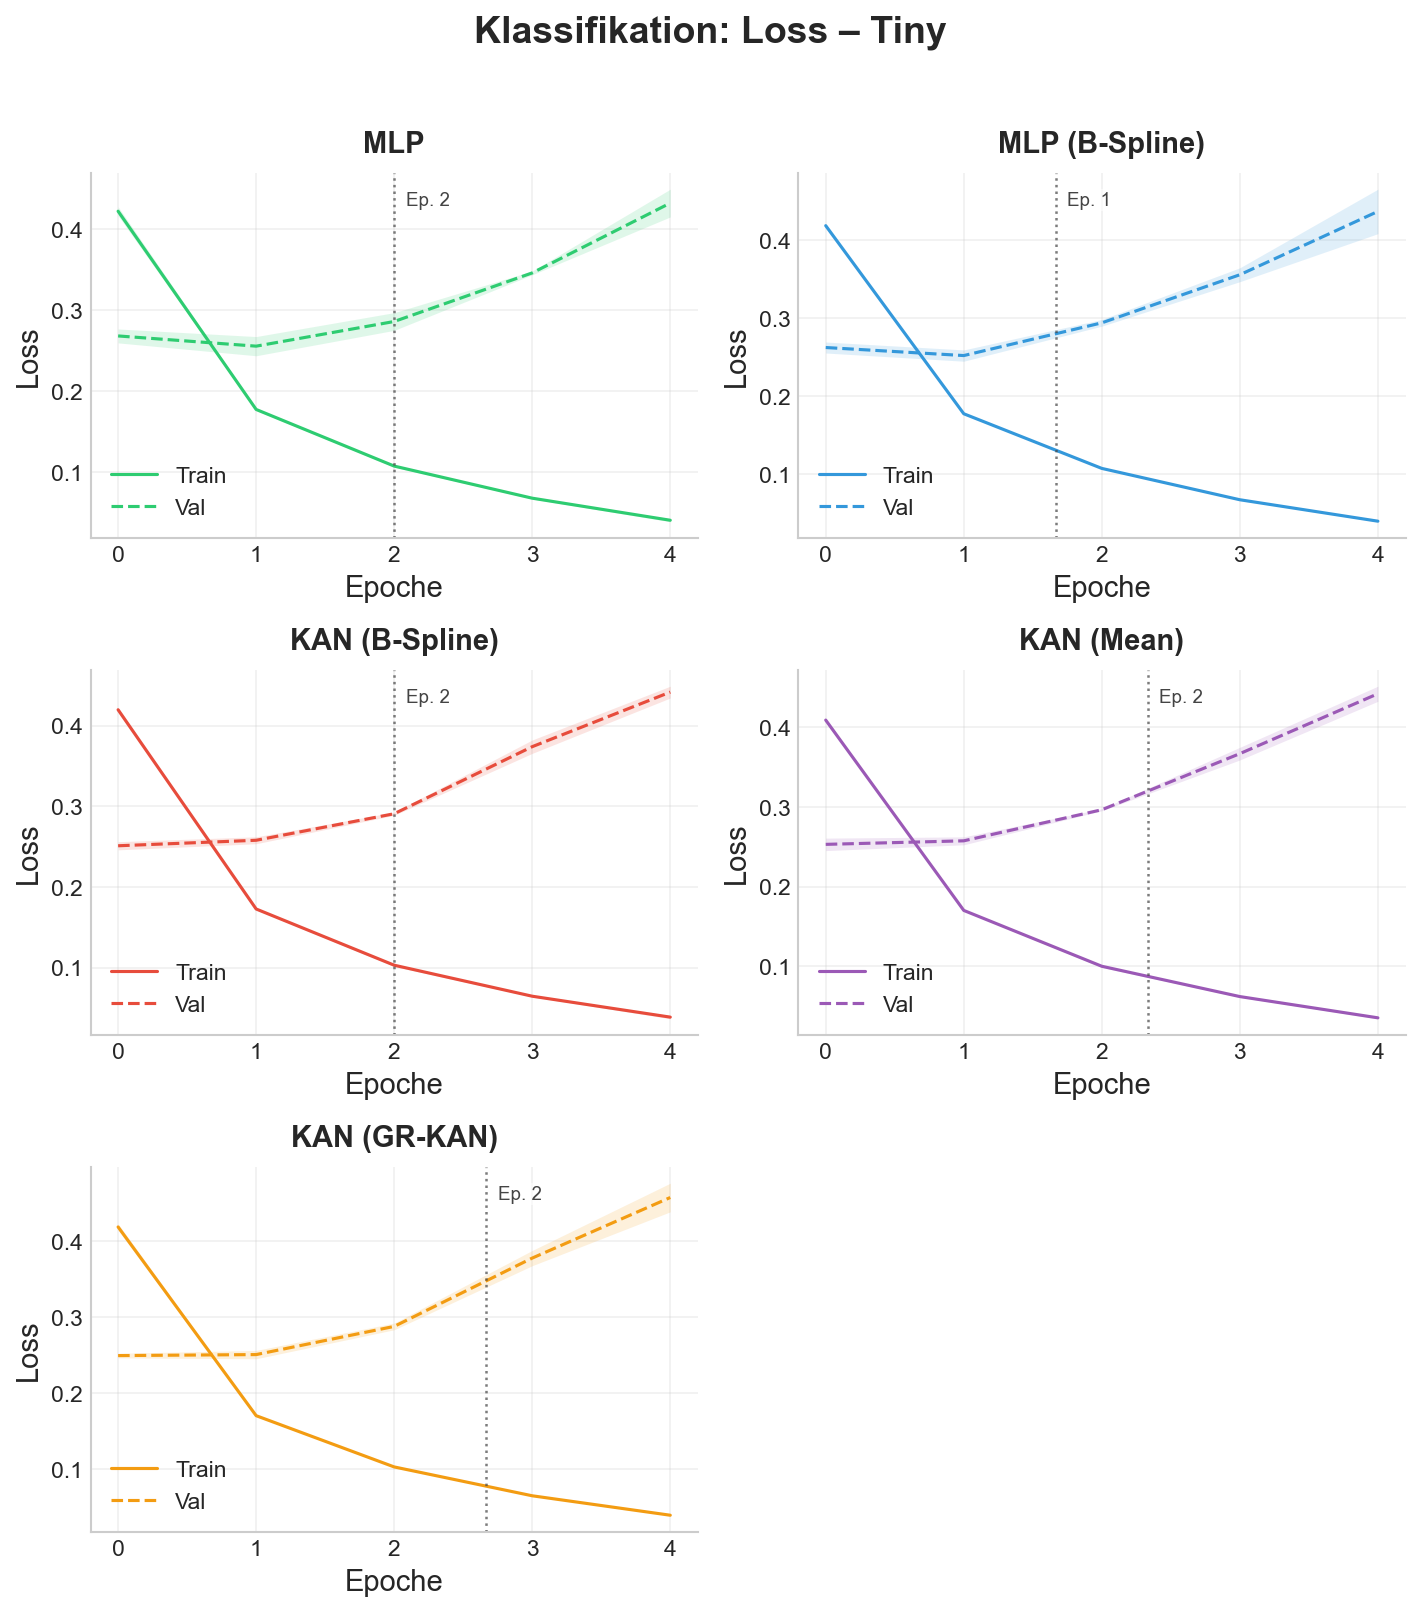

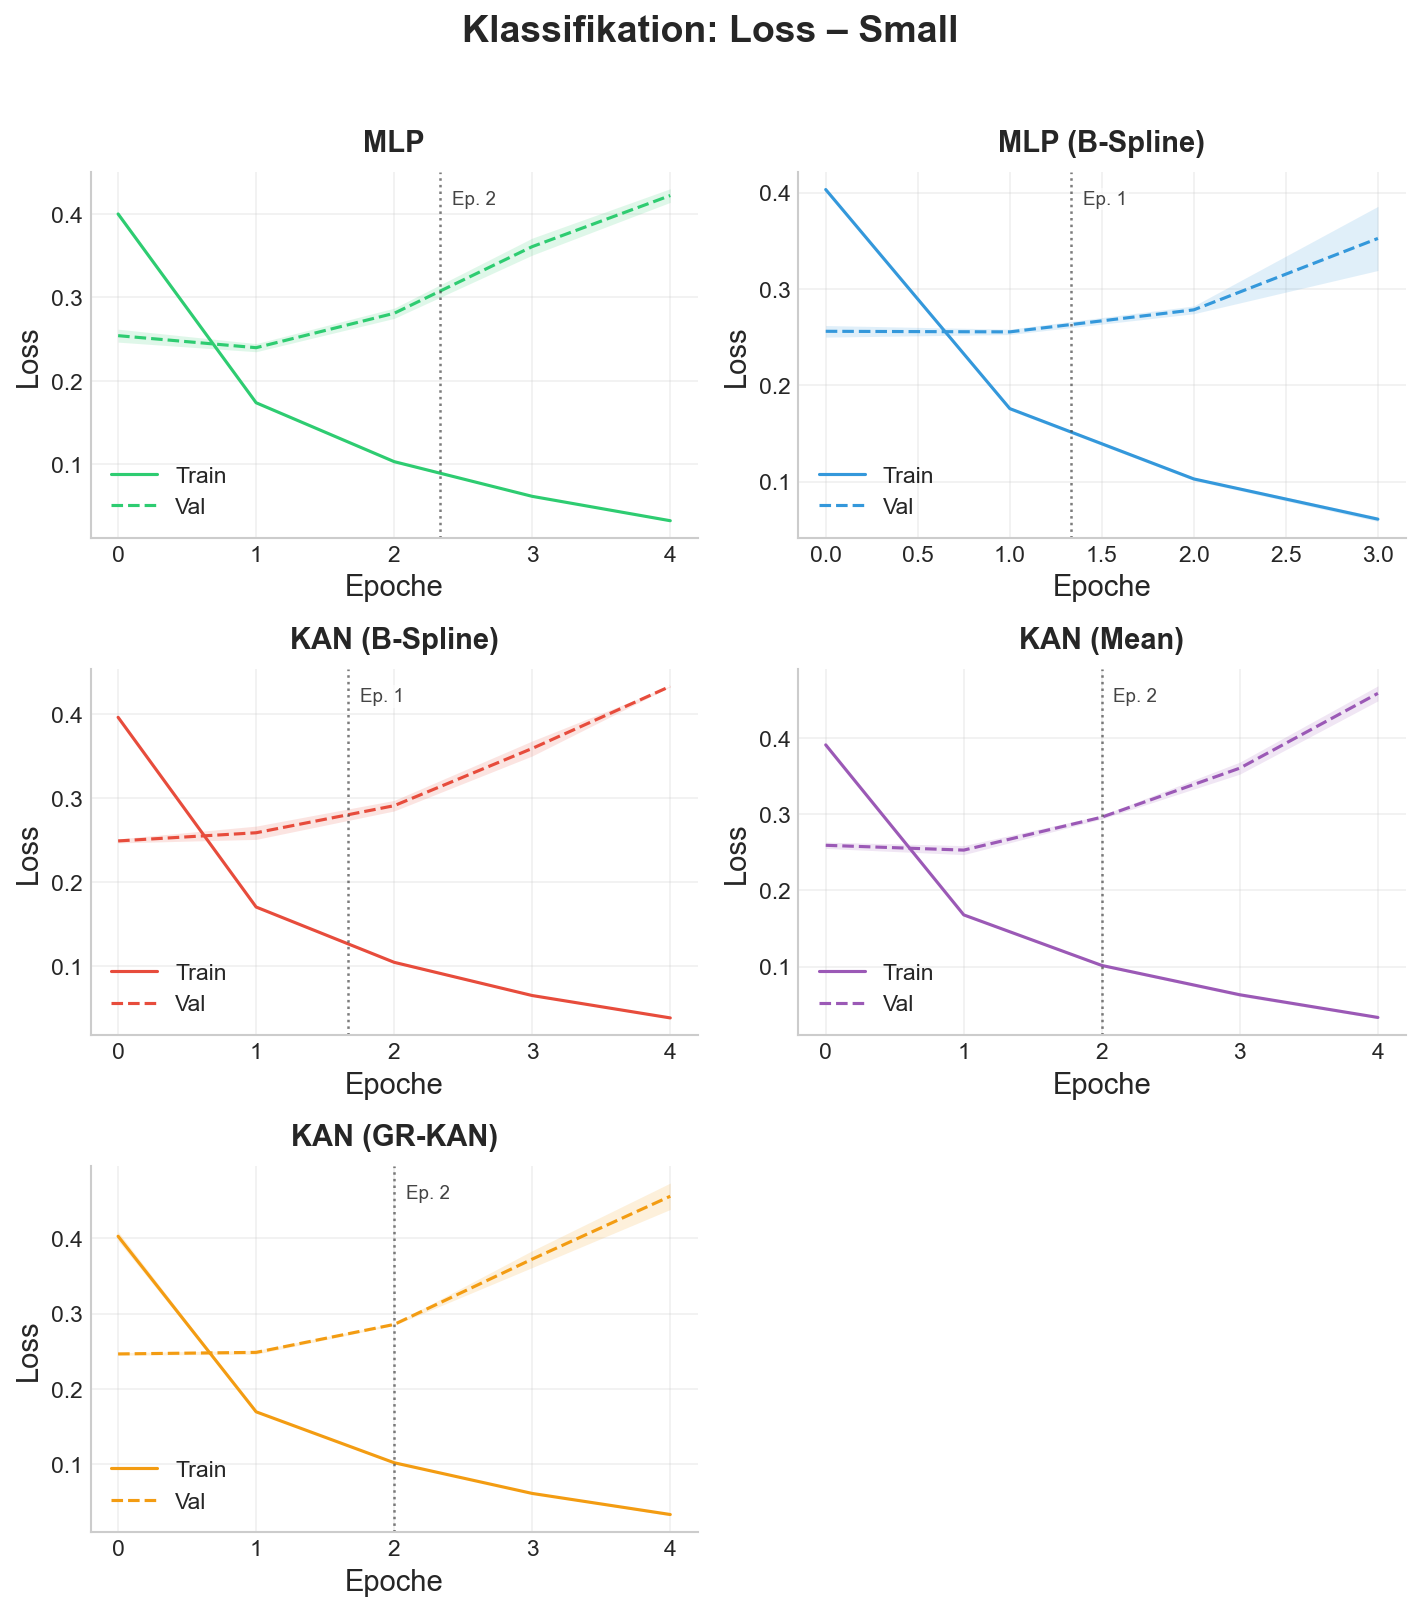

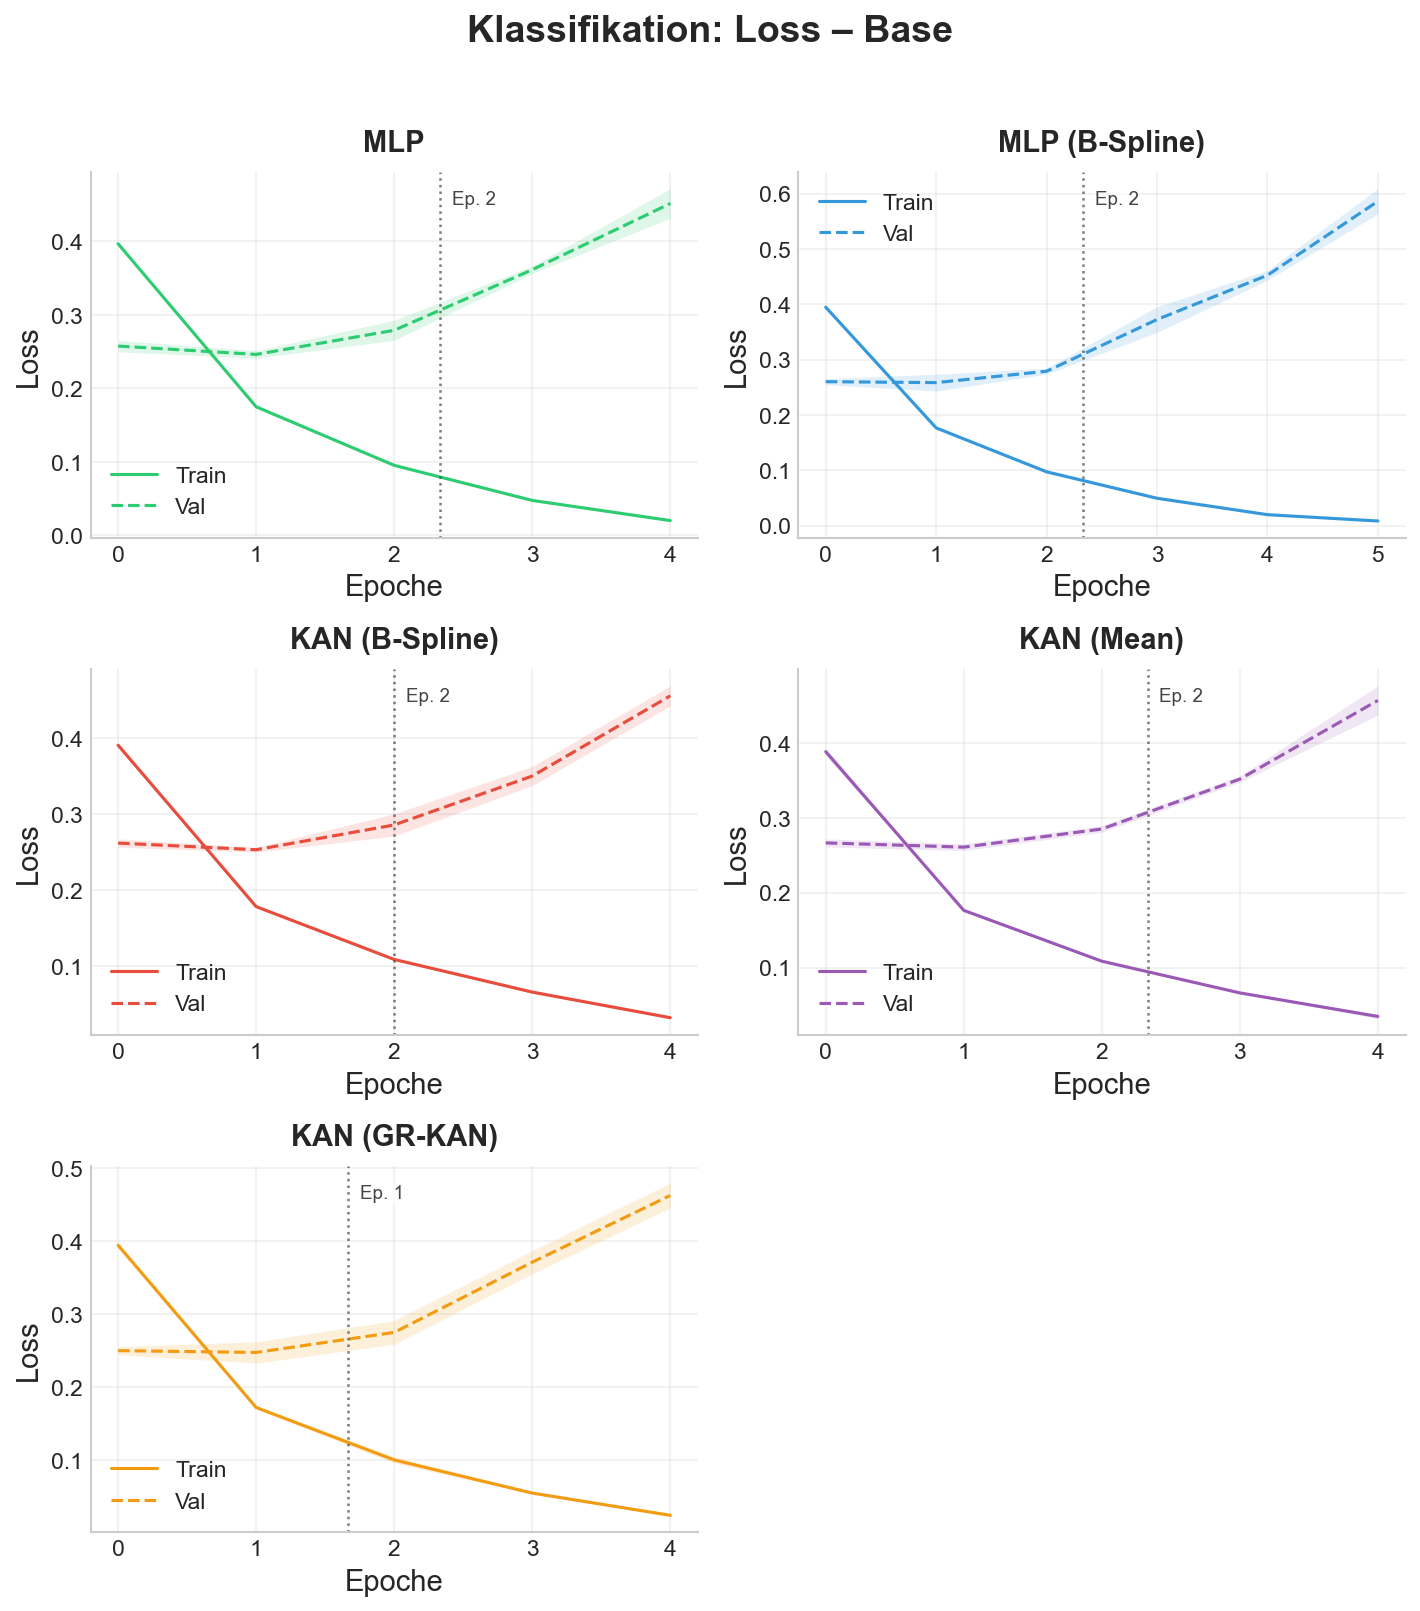

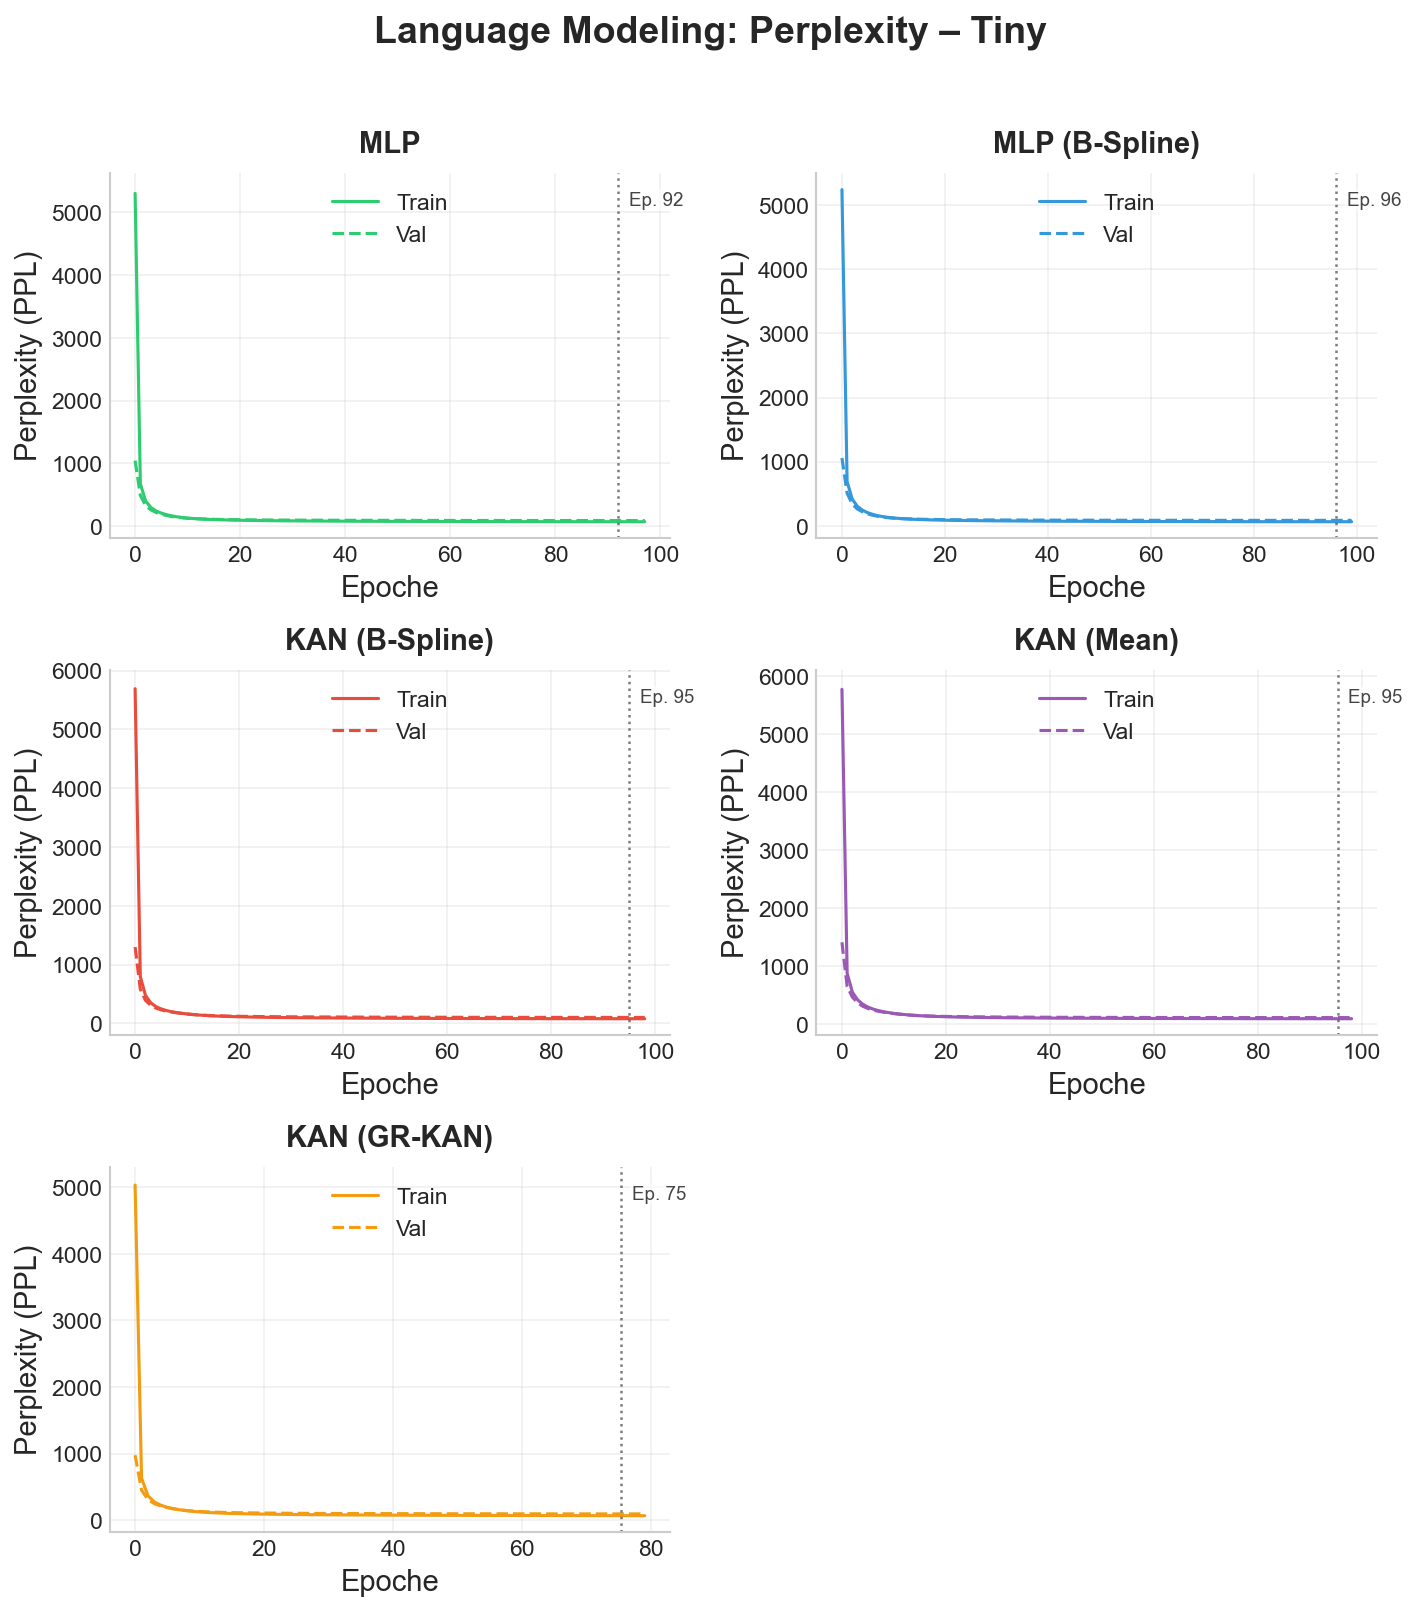

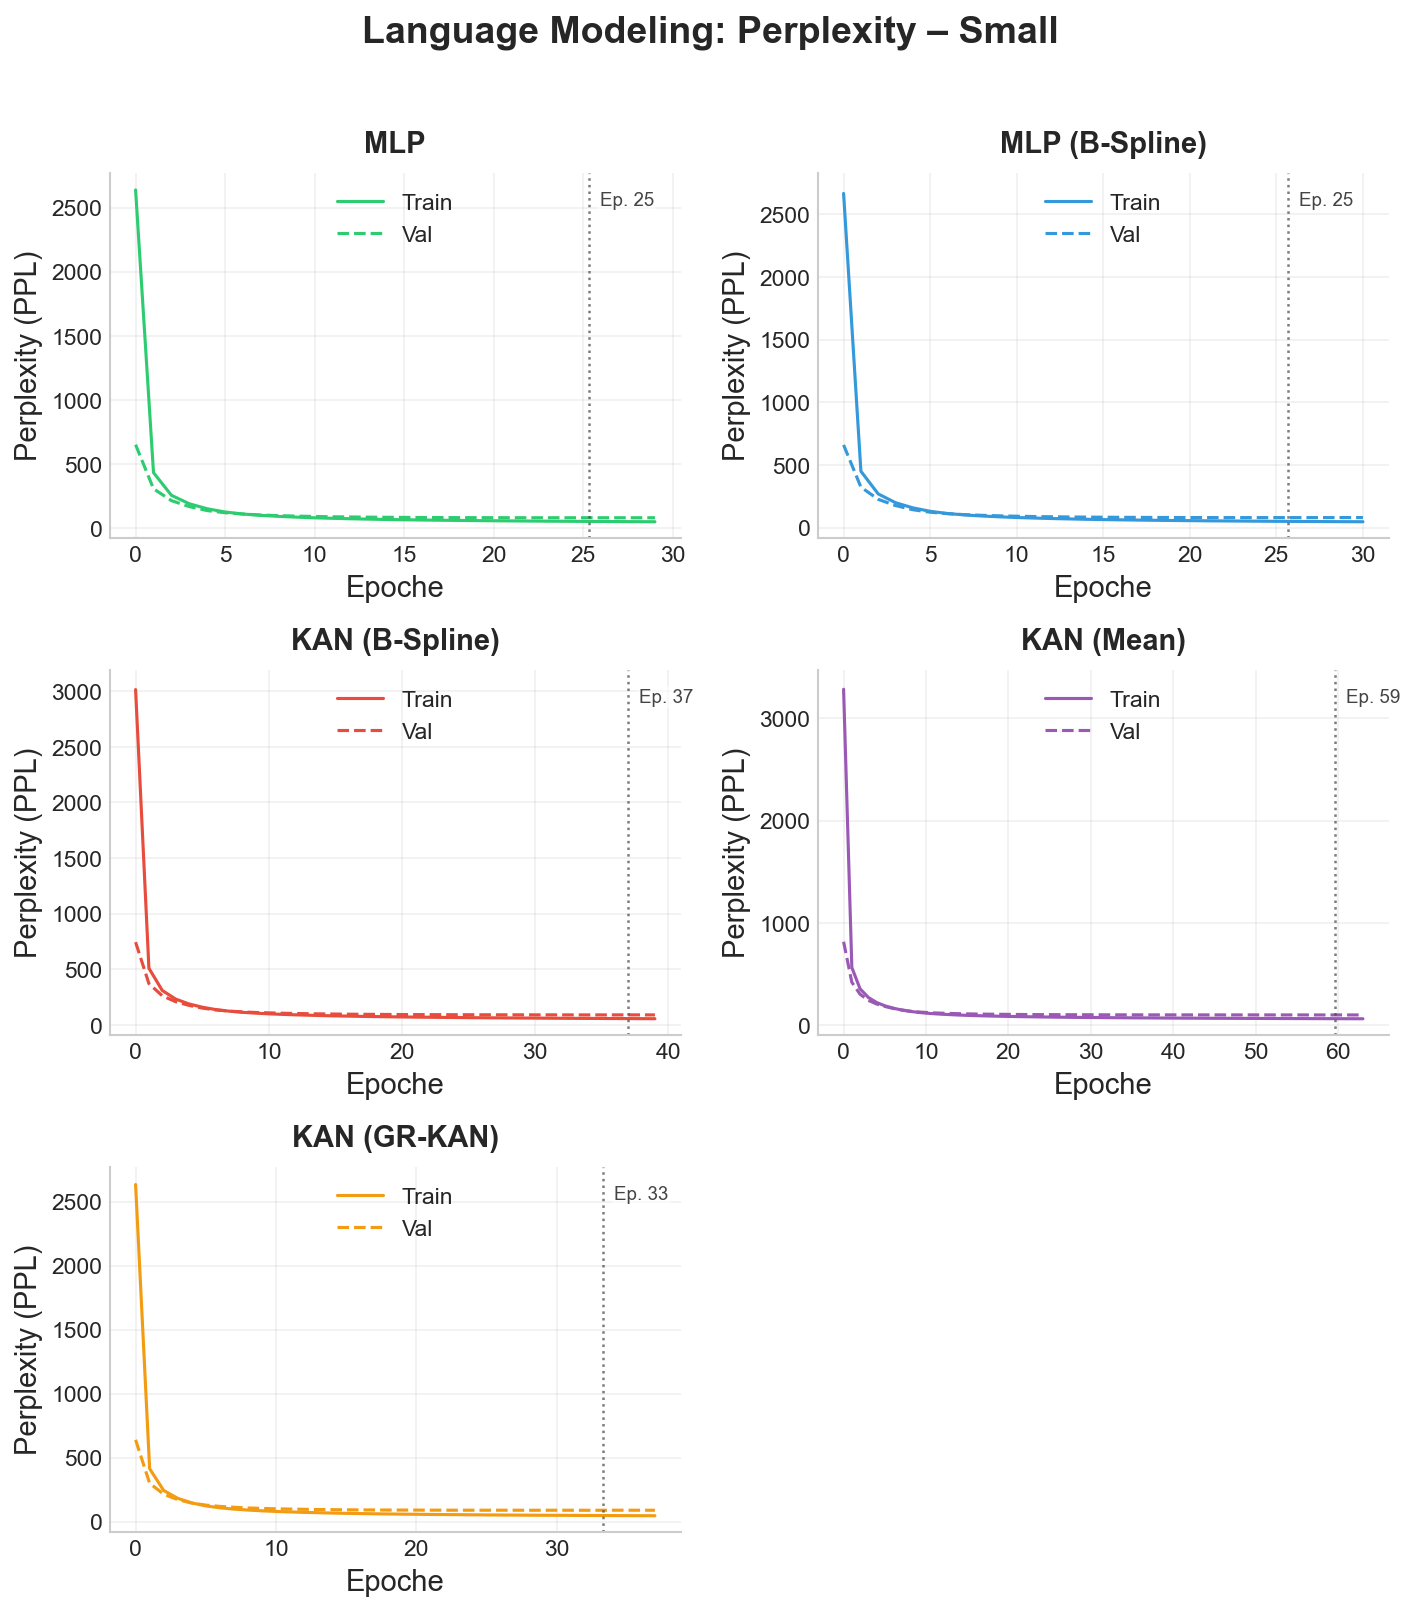

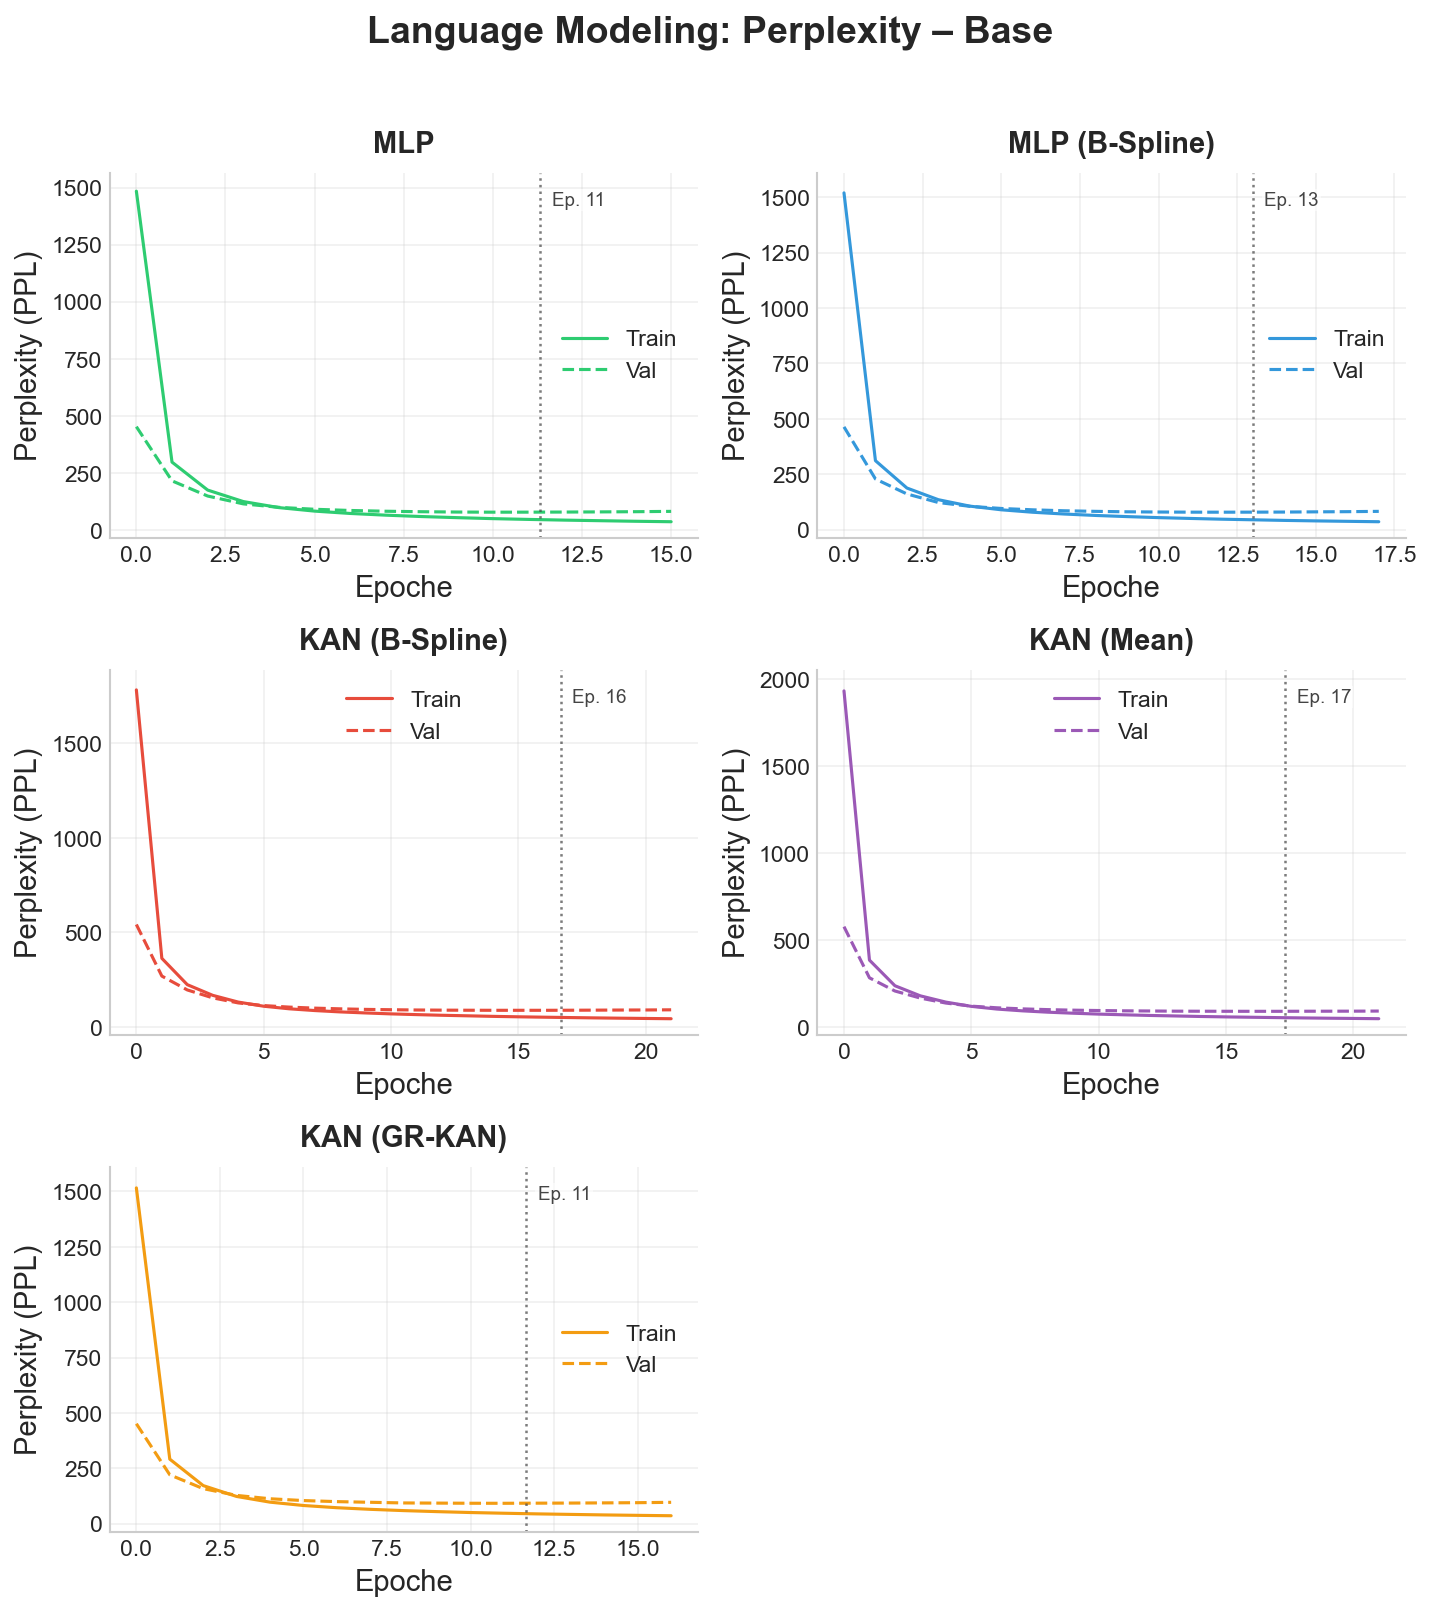

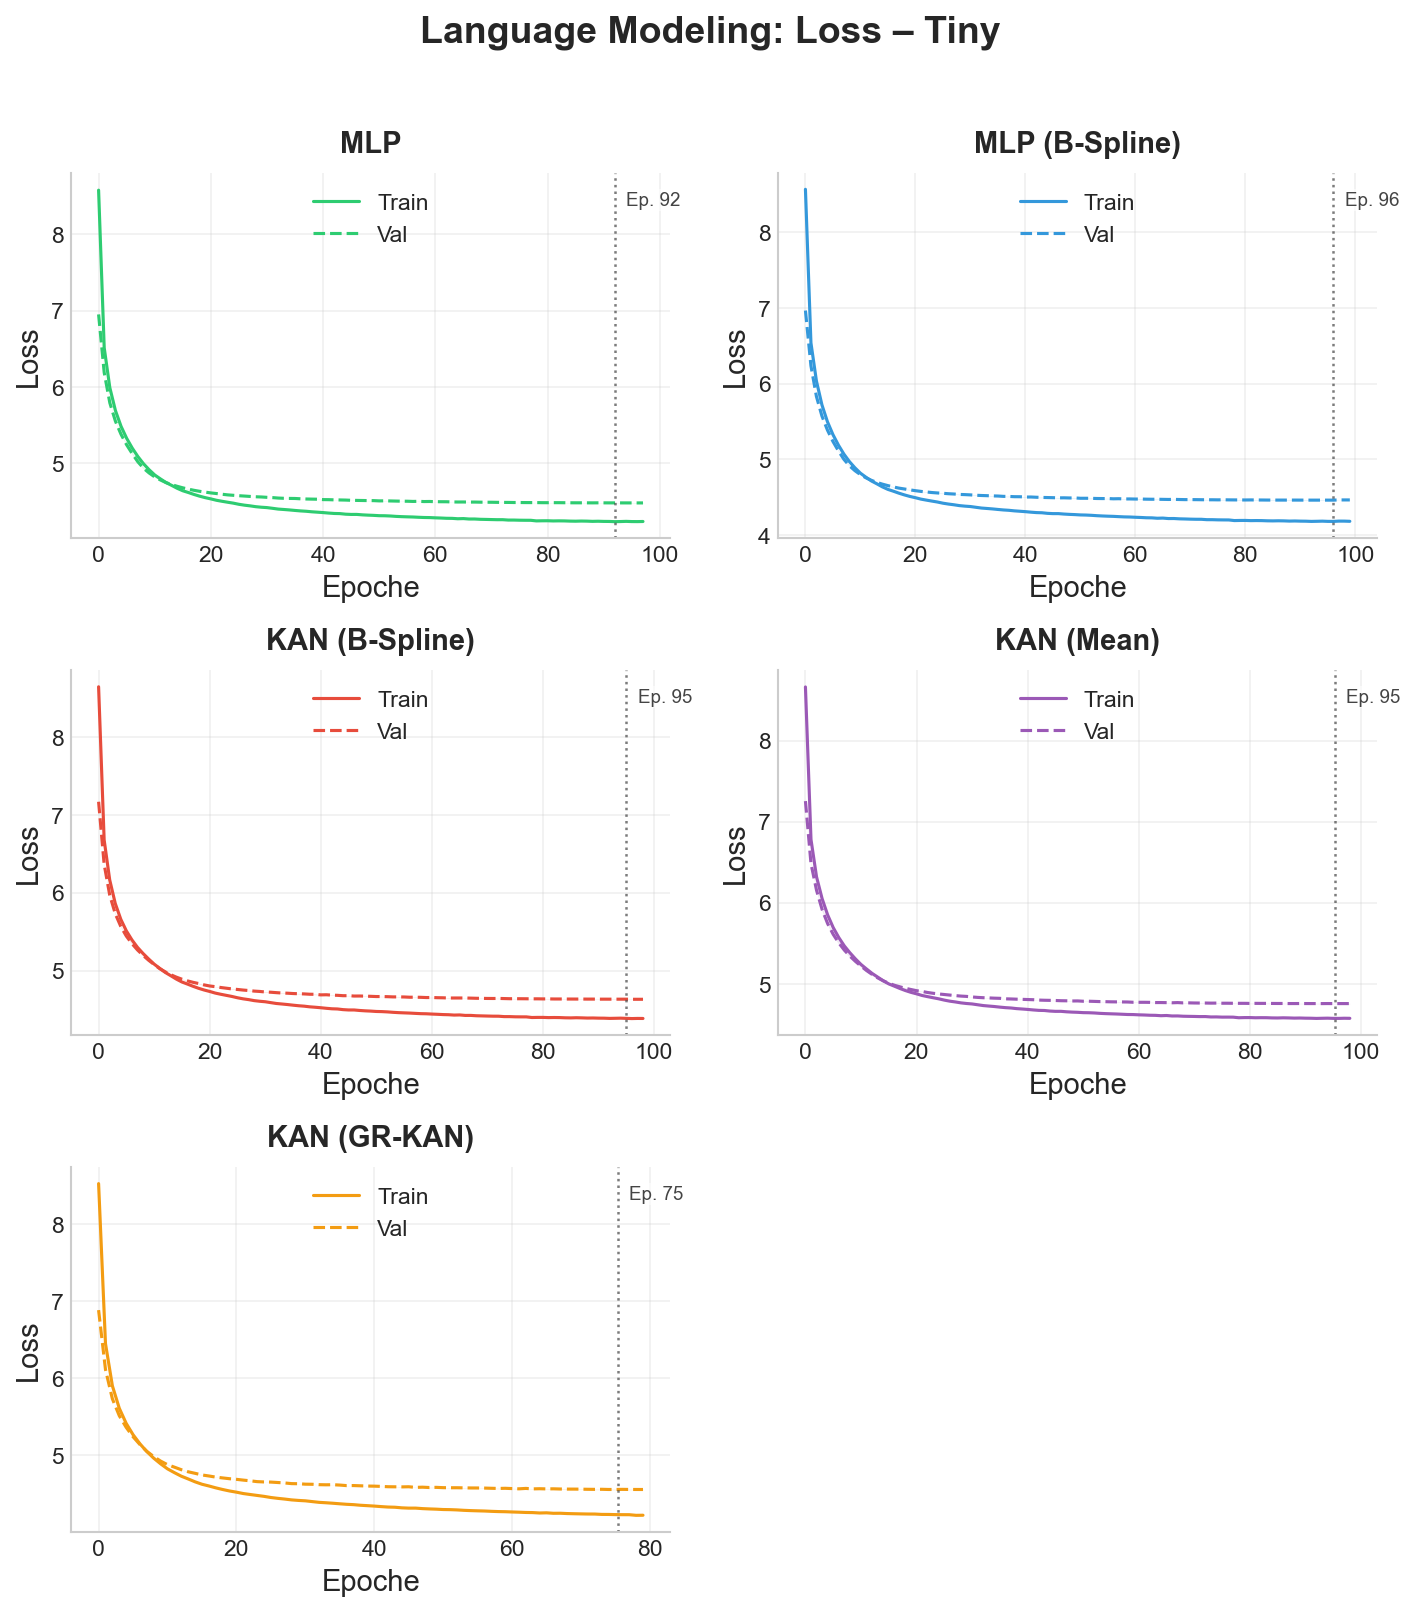

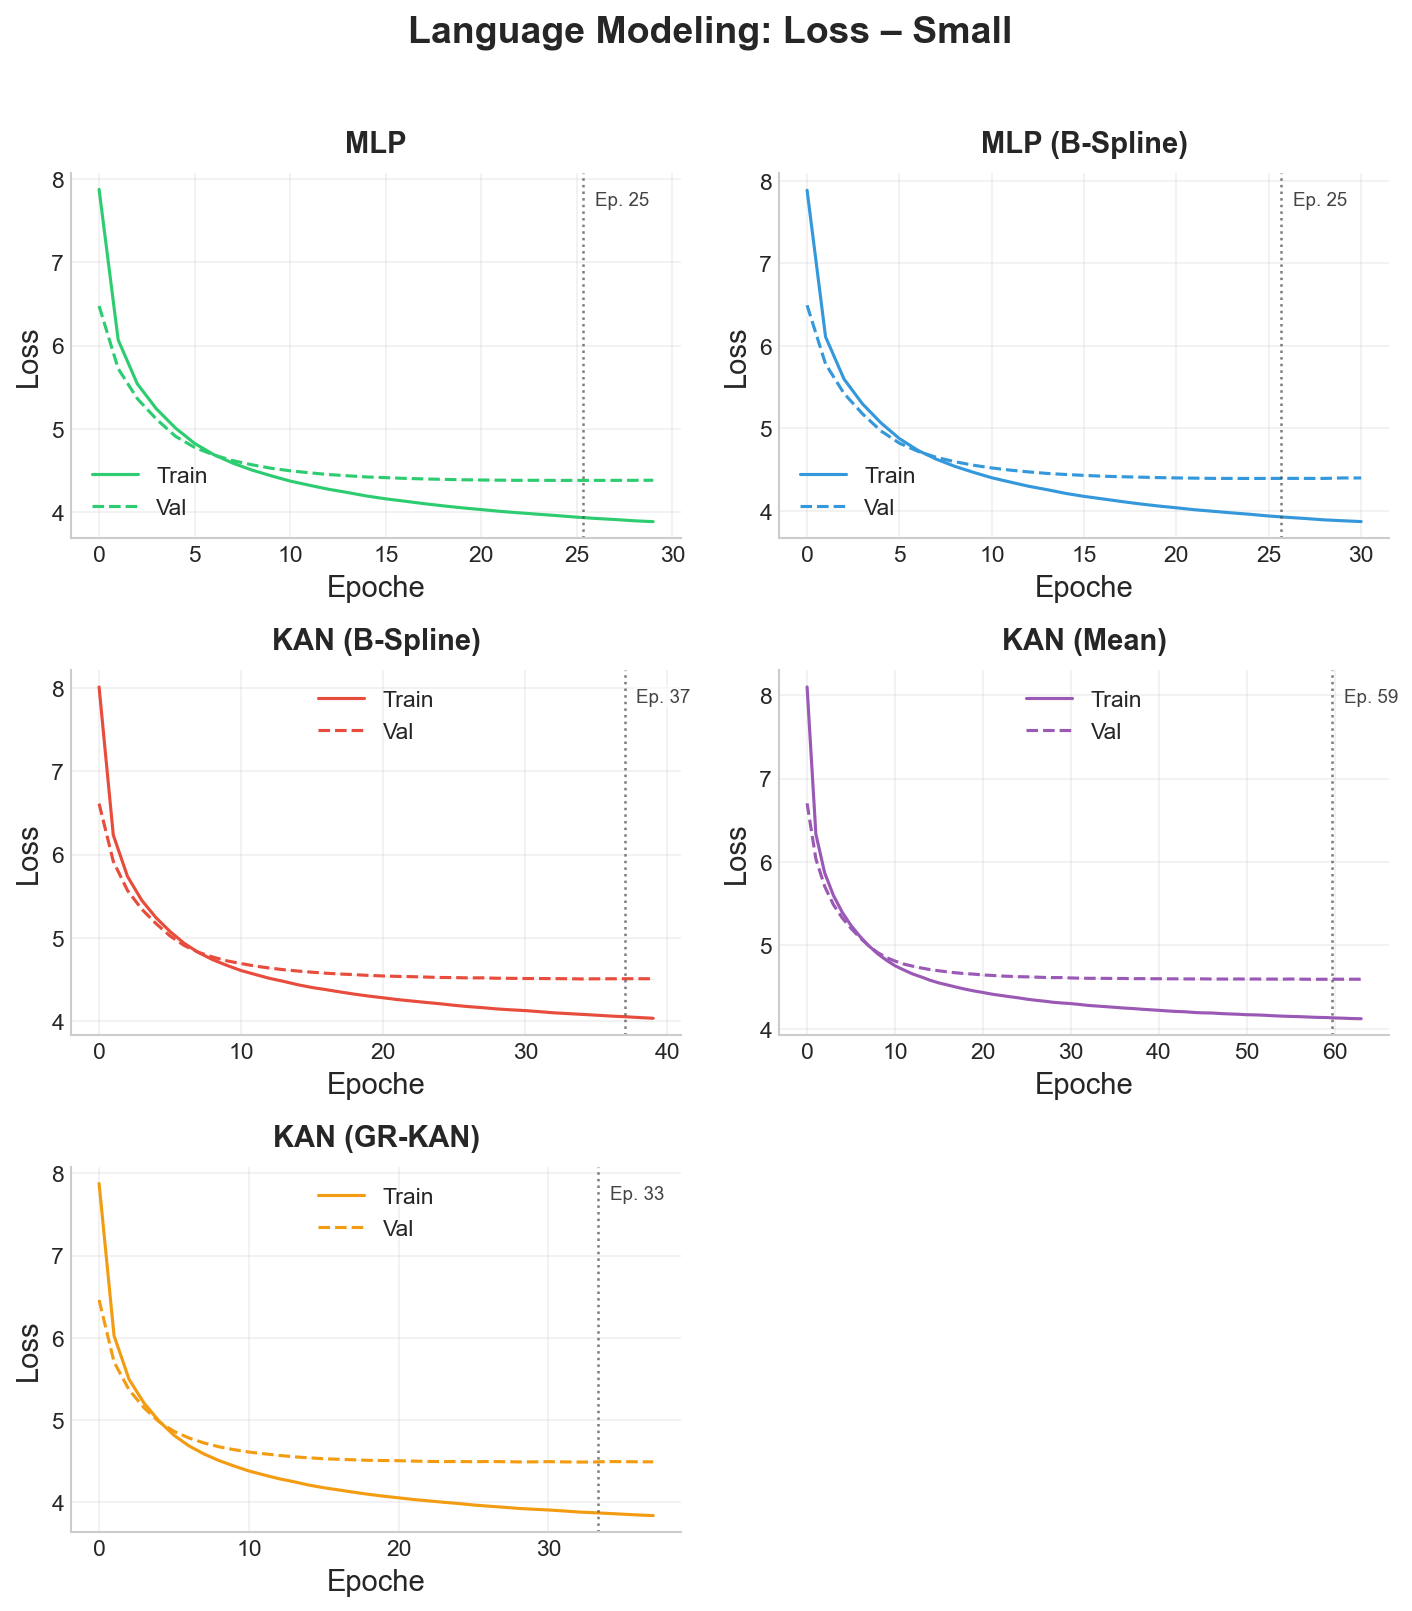

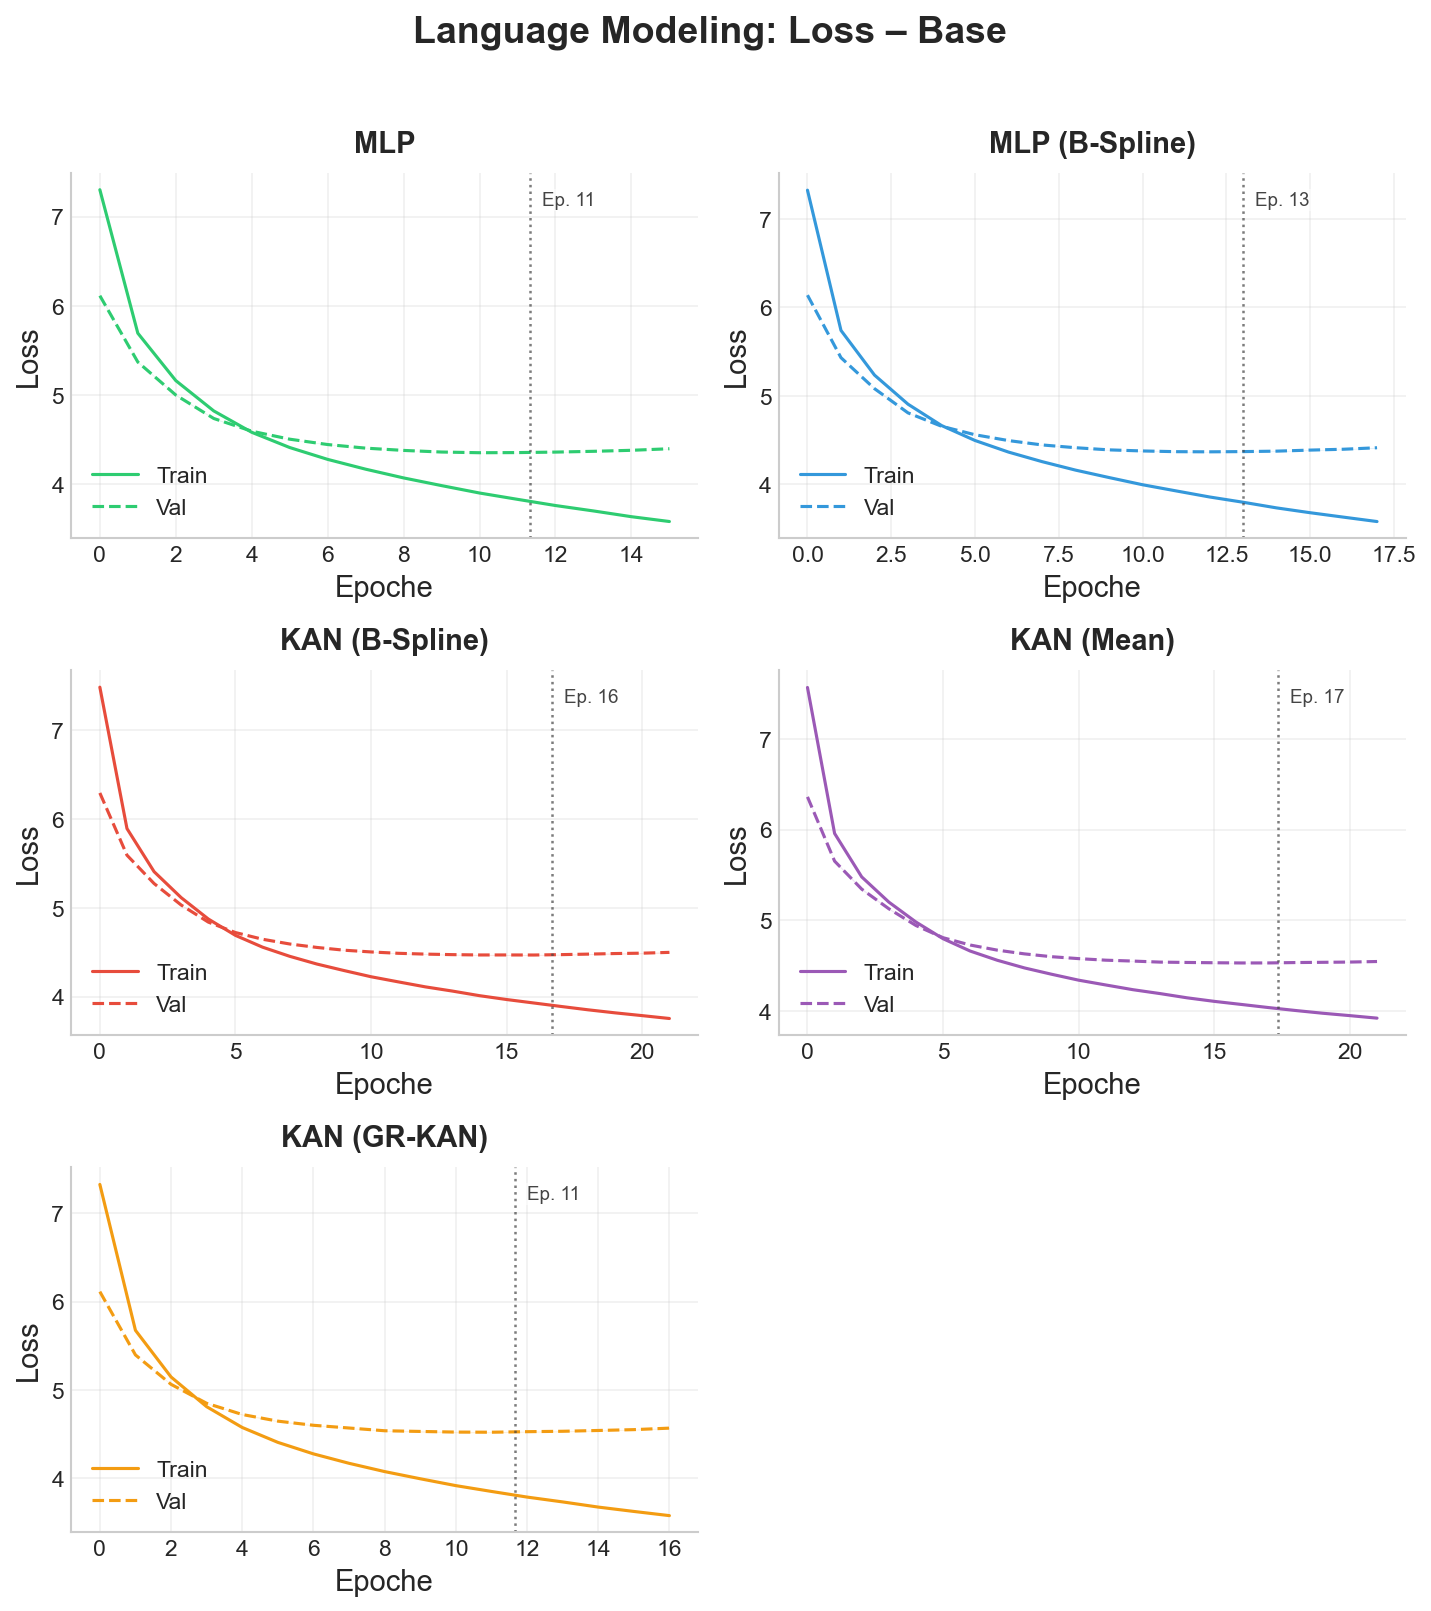

In [87]:
def plot_training_curves(hist_df, metric_train, metric_val, ylabel, title, size_filter=None, summary_df=None):
    if hist_df.empty:
        print("No history data found!")
        return None

    # Filter by size
    if size_filter:
        hist_df = hist_df[hist_df['size'] == size_filter].copy()
        if summary_df is not None:
            summary_df = summary_df[summary_df['size'] == size_filter].copy()

    # Arch with data only
    available_archs = [a for a in ARCH_ORDER if a in hist_df['Architecture'].unique()]
    n_archs = len(available_archs)

    if n_archs == 0:
        print("No architectures with data!")
        return None

    # Layout
    n_cols = 2
    n_rows = 3

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8 * n_cols, 3.5 * n_rows), squeeze=False)
    axes = axes.flatten()

    for idx, arch in enumerate(available_archs):
        ax = axes[idx]
        data = hist_df[hist_df['Architecture'] == arch]

        color = ARCH_COLORS.get(arch, 'black')

        # Helper function for mean + std
        def plot_metric(ax, df, metric_col, label, style, col):
            if metric_col not in df.columns:
                return
            # group by epoch and calc mean + std
            grouped = df.groupby('epoch')[metric_col].agg(['mean', 'std']).reset_index().dropna()

            # Plot
            ax.plot(grouped['epoch'], grouped['mean'],
                   color=col, linestyle=style, label=label, linewidth=1.5)

            # std shadow
            ax.fill_between(grouped['epoch'],
                           grouped['mean'] - grouped['std'],
                           grouped['mean'] + grouped['std'],
                           color=col, alpha=0.15, linewidth=0)

        # Train & Val
        plot_metric(ax, data, metric_train, 'Train', '-', color)
        plot_metric(ax, data, metric_val, 'Val', '--', color)

        # Early Stopping
        if summary_df is not None:
            arch_summary = summary_df[summary_df['Architecture'] == arch]
            if not arch_summary.empty and 'best_epoch' in arch_summary.columns:
                best_ep = arch_summary['best_epoch'].mean()
                if pd.notna(best_ep):
	                # Vertical line for best epoch
                    ax.axvline(x=best_ep, color='#444444', linestyle=':', alpha=0.7, linewidth=1.2)

                    # Label for epoch
                    y_min, y_max = ax.get_ylim()
                    ax.text(best_ep + (ax.get_xlim()[1]*0.02), y_max - (y_max-y_min)*0.05,
                           f'Ep. {int(best_ep)}',
                           color='#444444', fontsize=9, va='top', ha='left',
                           bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

        # Labels
        ax.set_xlabel('Epoche')
        ax.set_ylabel(ylabel)
        ax.set_title(arch, fontsize=14, fontweight='bold', pad=10)

        # Legend
        ax.legend(loc='best', frameon=False, fancybox=True, edgecolor='black', framealpha=0.8)

        # Remove upper borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Hide empty plots
    for idx in range(n_archs, len(axes)):
        axes[idx].set_visible(False)

    size_str = f' – {size_filter.capitalize()}' if size_filter else ''

    # Suptitle
    fig.suptitle(f'{title}{size_str}', fontsize=18, y=1.02, fontweight='bold')

    plt.tight_layout()
    return fig

def save_and_show(fig, filename):
    if fig:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

# Classification Acc
if not hist_cls.empty:
    for size in SIZE_ORDER:
        fig = plot_training_curves(
            hist_cls,
            'train/epoch_avg_acc', 'val/acc',
            'Accuracy (%)',
            'Klassifikation: Trainingsverlauf',
            size_filter=size,
            summary_df=df_cls
        )
        save_and_show(fig, f'results/training_cls_acc_{size}.png')

# Classification Loss
if not hist_cls.empty:
    for size in SIZE_ORDER:
        fig = plot_training_curves(
            hist_cls,
            'train/epoch_avg_loss', 'val/loss',
            'Loss',
            'Klassifikation: Loss',
            size_filter=size,
            summary_df=df_cls
        )
        save_and_show(fig, f'results/training_cls_loss_{size}.png')

# Language Modeling PPL
if not hist_lm.empty:
    for size in SIZE_ORDER:
        fig = plot_training_curves(
            hist_lm,
            'train/epoch_avg_ppl', 'val/ppl',
            'Perplexity (PPL)',
            'Language Modeling: Perplexity',
            size_filter=size,
            summary_df=df_lm
        )
        save_and_show(fig, f'results/training_lm_ppl_{size}.png')

# Language Modeling Loss
if not hist_lm.empty:
    for size in SIZE_ORDER:
        fig = plot_training_curves(
            hist_lm,
            'train/epoch_avg_loss', 'val/loss',
            'Loss',
            'Language Modeling: Loss',
            size_filter=size,
            summary_df=df_lm
        )
        save_and_show(fig, f'results/training_lm_loss_{size}.png')

# Efficiency-Plots

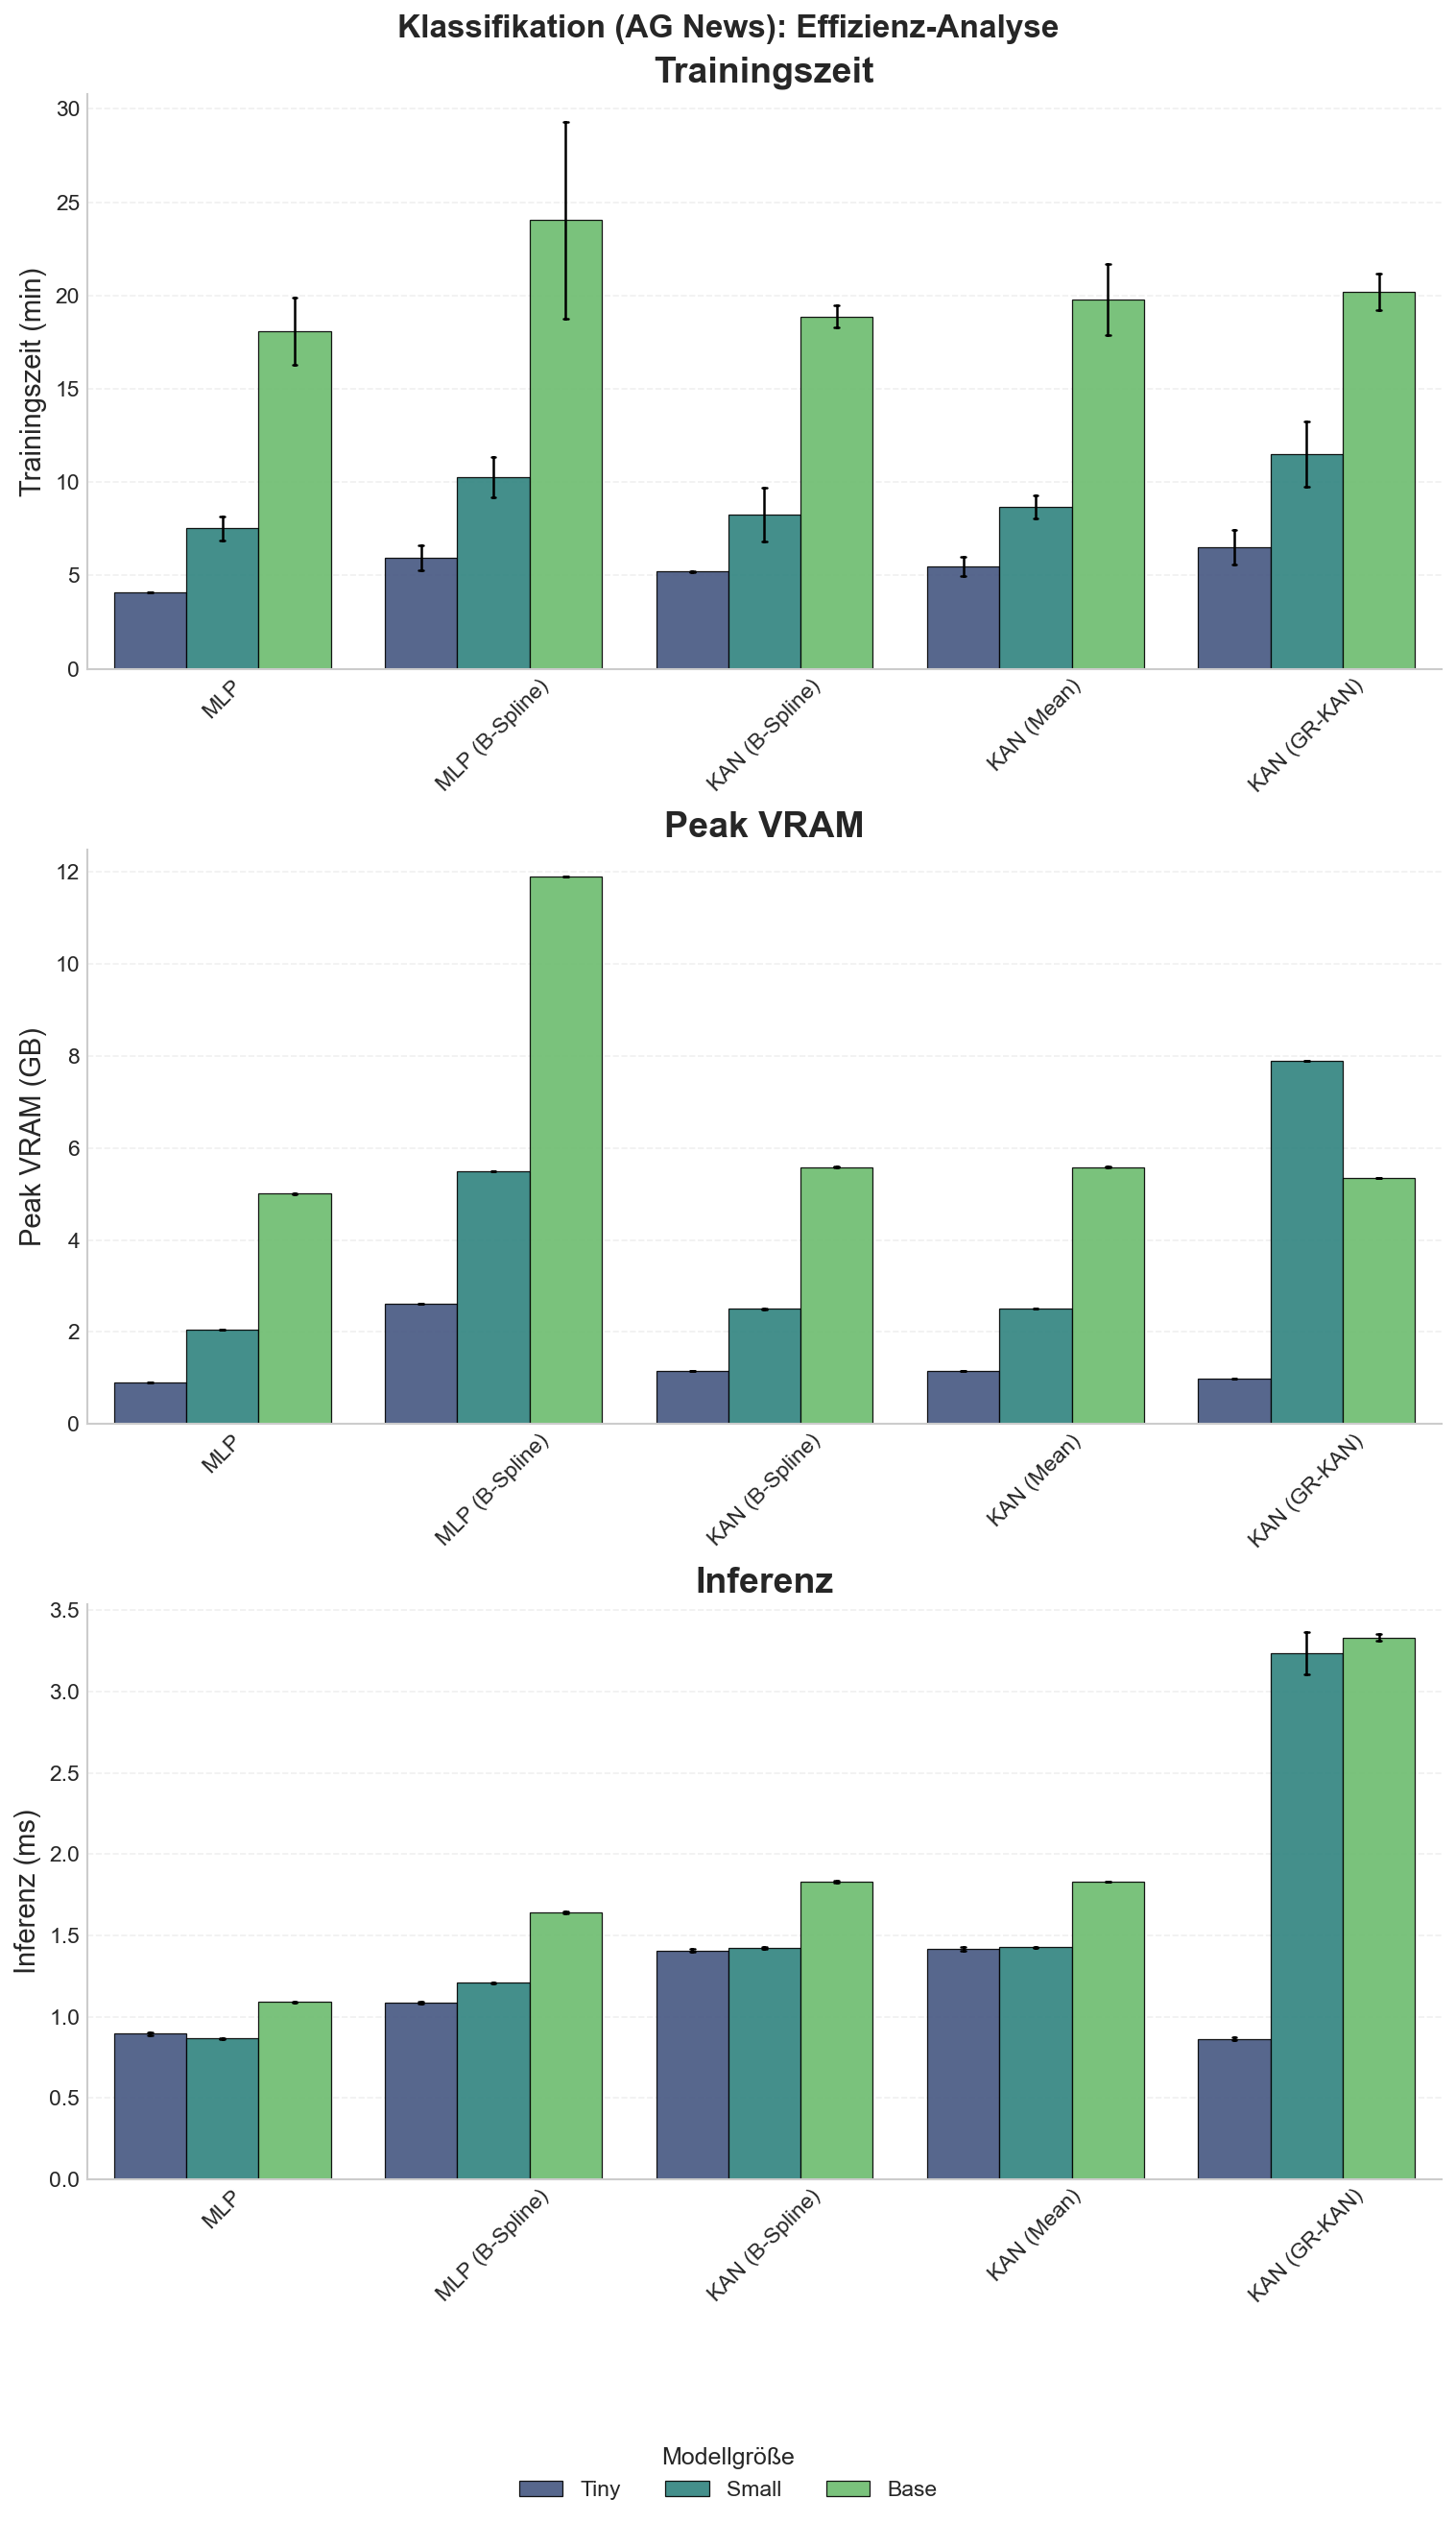

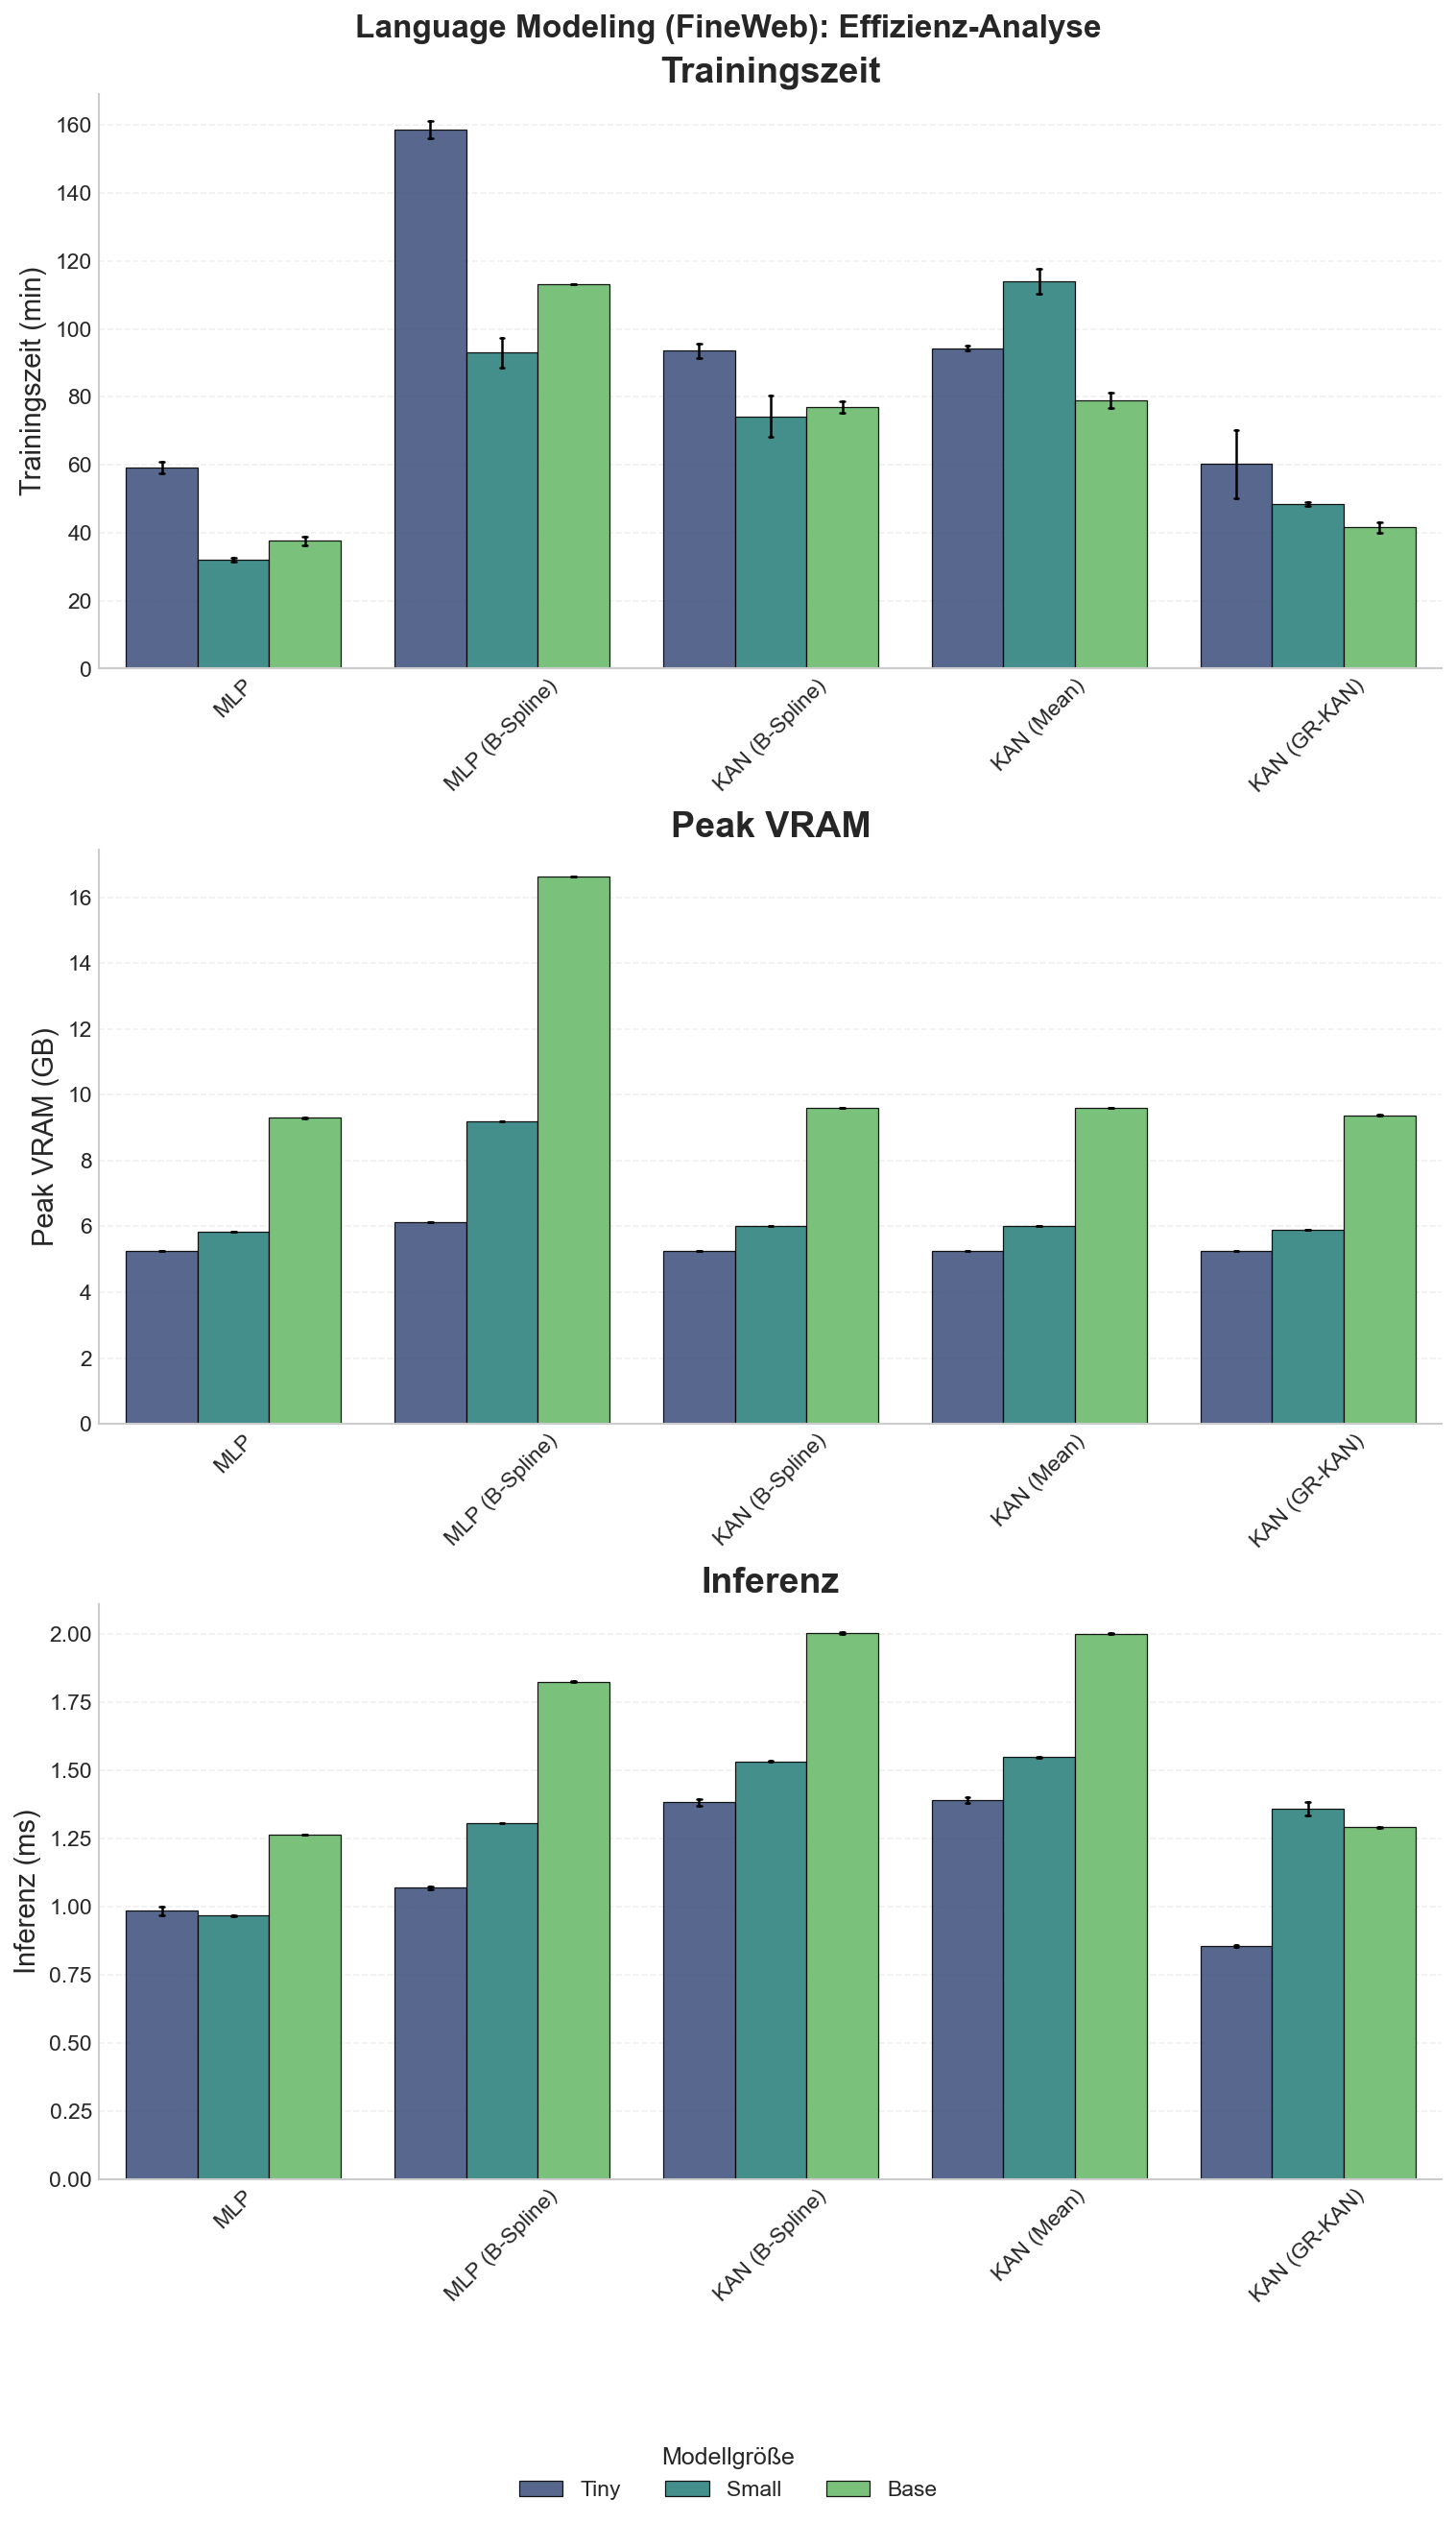

In [88]:
def plot_efficiency_panel(df, title_prefix, filename):
    if df.empty:
        print(f"Keine Daten für {title_prefix}")
        return

    # Metrics
    metrics = [
        ('time_min', 'Trainingszeit (min)'),
        ('peak_mem_gb', 'Peak VRAM (GB)'),
        ('inference_ms', 'Inferenz (ms)')
    ]

    # Plots
    fig, axes = plt.subplots(3, 1, figsize=(10, 16), constrained_layout=True)
    size_palette = "viridis"

    for ax, (metric, label) in zip(axes, metrics):
        sns.barplot(
            data=df,
            x='Architecture',
            y=metric,
            hue='size',
            hue_order=SIZE_ORDER,
            order=ARCH_ORDER,
            errorbar='sd',
            palette=size_palette,
            edgecolor='black',
            linewidth=0.6,
            capsize=0.05,
            err_kws={'linewidth': 1.2, 'color': 'black'},
            ax=ax,
            alpha=0.9
        )

        # Style
        ax.set_ylabel(label)
        ax.set_xlabel('')
        ax.set_title(label.split(' (')[0], fontweight='bold')
        ax.tick_params(axis='x', rotation=45)

        # Grid
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        sns.despine(ax=ax)

        # Legend once globally
        ax.get_legend().remove()

    handles, labels = axes[0].get_legend_handles_labels()
    # Labels caps
    labels = [l.capitalize() for l in labels]

    # Legend
    fig.legend(
        handles, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=3,
        frameon=False,
        title='Modellgröße',
        fontsize=11,
        title_fontsize=12
    )

    # title
    fig.suptitle(f'{title_prefix}: Effizienz-Analyse', fontsize=16, fontweight='bold')

    # Save
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

if not df_cls.empty:
    plot_efficiency_panel(df_cls, 'Klassifikation (AG News)', 'results/efficiency_cls.png')

if not df_lm.empty:
    plot_efficiency_panel(df_lm, 'Language Modeling (FineWeb)', 'results/efficiency_lm.png')